In [16]:
import pandas as pd

df = pd.read_parquet("group_hash.snappy.parquet")

import pandas as pd
from pyspark.sql.functions import pandas_udf, ceil
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

# import recordlinkage
import pandas as pd
import re
import hashlib
import textdistance
from abydos.phonetic import SpanishMetaphone
from unidecode import unidecode
import networkx
from networkx.algorithms.components.connected import connected_components
from pyspark import SparkContext, SparkConf
import ibis
import json
from pyspark.sql import functions as F
from pyspark.sql import types as T

spark = SparkSession.builder.appName("ConnectedComponents").getOrCreate()

df = spark.createDataFrame(df)

def dob_cluster(df, spark):
    df.createOrReplaceTempView("df_dedupe")
    df_dob = spark.sql("select distinct DateOfBirth from df_dedupe limit 100")
    df_dob.createOrReplaceTempView("df_dedupe")
    def damerau_levenshtein_udf(a, b):
        return textdistance.damerau_levenshtein.distance(a, b)
    spark.udf.register("damerau_levenshtein_udf", damerau_levenshtein_udf, T.StringType())
    df_dob_cross_join = spark.sql(
        """
        select * from (SELECT DateOfBirth,DateOfBirth_right , damerau_levenshtein_udf(DateOfBirth,DateOfBirth_right) AS distance
        FROM (select df_dedupe.DateOfBirth as DateOfBirth, df_dedupe1.DateOfBirth as DateOfBirth_right from df_dedupe cross join df_dedupe as df_dedupe1 where df_dedupe.DateOfBirth != df_dedupe1.DateOfBirth)) where distance <= 1
    """
    )

    dob_tag_list = df_dob_cross_join.toPandas()[["DateOfBirth","DateOfBirth_right"]].to_numpy()

    def to_graph(l):
        G = networkx.Graph()
        for part in l:
            # each sublist is a bunch of nodes
            G.add_nodes_from(part)
            # it also imlies a number of edges:
            G.add_edges_from(to_edges(part))
        return G

    def to_edges(l):
        """
        treat `l` as a Graph and returns it's edges
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
        """
        it = iter(l)
        last = next(it)

        for current in it:
            yield last, current
            last = current

    G = to_graph(dob_tag_list)
    cluster = [list(x) for x in list(connected_components(G))]
    dob = []
    dob_hash = []
    for ind, each in enumerate(cluster):
        for each_element in each:
            dob.append(each_element)
            dob_hash.append(hashlib.md5(str(each[0]).encode("utf-8")).hexdigest())
    spark.createDataFrame(pd.DataFrame(
        {"dob": dob, "dob_hash": dob_hash}
    )).createOrReplaceTempView("df_dob_cluster")
    df.createOrReplaceTempView("df_dedupe")
    return spark.sql("select df_dedupe.*, df_dob_cluster.dob_hash from df_dedupe join df_dob_cluster on df_dedupe.DateOfBirth == df_dob_cluster.dob")
dob_cluster(df,spark).collect()

/home/anorak/CeBu-CDP-pyspark/ccai_cdp_env/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/home/anorak/CeBu-CDP-pyspark/ccai_cdp_env/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


23/08/06 21:57:04 WARN SimpleFunctionRegistry: The function damerau_levenshtein_udf replaced a previously registered function.
23/08/06 21:57:04 WARN TaskSetManager: Stage 111 contains a task of very large size (6470 KiB). The maximum recommended task size is 1000 KiB.


/home/anorak/CeBu-CDP-pyspark/ccai_cdp_env/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/home/anorak/CeBu-CDP-pyspark/ccai_cdp_env/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


23/08/06 21:57:06 WARN TaskSetManager: Stage 120 contains a task of very large size (6470 KiB). The maximum recommended task size is 1000 KiB.


[Row(ProvisionalPrimaryKey='326540187_9487190', FirstName='harry jr', LastName='davis', DateOfBirth='1948-01-30', Gender='1', PassengerID=326540187, pFirstName='ARRY', pLastName='DVS', group_hash='57097b72db972a7532727a2b810cabda', dob_hash='42cd21d558127ea7f6fae41f97245fa4'),
 Row(ProvisionalPrimaryKey='319493171_9487190', FirstName='teresita', LastName='alcazar', DateOfBirth='1948-01-30', Gender='2', PassengerID=319493171, pFirstName='TRST', pLastName='ALKZR', group_hash='60916633a4ccc935e665f7c8f15f0c1a', dob_hash='42cd21d558127ea7f6fae41f97245fa4'),
 Row(ProvisionalPrimaryKey='317443348_9487190', FirstName='melinda', LastName='suarez', DateOfBirth='1957-07-10', Gender='2', PassengerID=317443348, pFirstName='MLND', pLastName='SRZ', group_hash='2fde190222e11a6663c4d8511e291927', dob_hash='9077adf7c9cdeec534525718be08dbd7'),
 Row(ProvisionalPrimaryKey='324787841_9487190', FirstName='nemia', LastName='alcantara', DateOfBirth='1957-07-10', Gender='2', PassengerID=324787841, pFirstName='

In [35]:
import pandas as pd

df = pd.read_parquet("group_hash.snappy.parquet")

import pandas as pd
from pyspark.sql.functions import pandas_udf, ceil
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

# import recordlinkage
import pandas as pd
import re
import hashlib
import textdistance
from abydos.phonetic import SpanishMetaphone
from unidecode import unidecode
import networkx
from networkx.algorithms.components.connected import connected_components
from pyspark import SparkContext, SparkConf
import ibis
import json

spark = SparkSession.builder.appName("ConnectedComponents").getOrCreate()

df = spark.createDataFrame(df)

ccSchema = T.StructType(
    [
        T.StructField("group_hash", T.StringType()),
        # T.StructField('passenger_hash_dict',T.ArrayType(T.StructType([StructField("ProvisionalPrimaryKey",StringType(),True),StructField("passenger_hash",StringType(),True)]))),
        # T.StructField("passenger_hash_dict", T.ArrayType(T.StringType())),
        T.StructField("passenger_hash_dict", T.StringType()),
    ]
)


def cc_nx(df: pd.DataFrame) -> pd.DataFrame:
    # print("SHAPE",df.shape,df.columns)
    gp = df["group_hash"].iloc[0]
    phd = {
        "ProvisionalPrimaryKey": df["ProvisionalPrimaryKey"].iloc[0],
        "passenger_hash": hashlib.md5(
            str(df["ProvisionalPrimaryKey"].iloc[0]).encode("utf-8")
        ).hexdigest(),
    }
    # return pd.DataFrame(
    #         {
    #             "group_hash": [df["group_hash"].iloc[0],df["group_hash"].iloc[0],df["group_hash"].iloc[0]],
    #             "passenger_hash_dict": [json.dumps(phd),json.dumps(phd),json.dumps(phd)],
    #             # "passenger_hash_dict": [phd],
    #         }
    #     )
    # phd = "1"
    if df.shape[0] == 1:
        return pd.DataFrame(
            {
                "group_hash": [df["group_hash"].iloc[0]],
                "passenger_hash_dict": [json.dumps(phd)],
                # "passenger_hash_dict": [phd],
            }
        )

    ibis.duckdb.connect()
    ibis.options.interactive = False
    df = ibis.memtable(df, name="df")
    df1 = df.view()
    df = df.join(df1, ((df.PassengerID < df1.PassengerID)))
    from ibis import udf

    @udf.scalar.python
    def jaro_winkler_udf(a: str, b: str) -> float:
        return textdistance.jaro_winkler.similarity(a, b)

    @udf.scalar.python
    def damerau_levelstien_udf(a: str, b: str) -> float:
        return textdistance.damerau_levenshtein.distance(a, b)

    FirstNameSim = (
        ibis.case()
        .when(
            ((df.FirstName != "CCAI_NULL") & (df.FirstName_right != "CCAI_NULL")),
            jaro_winkler_udf(df.FirstName, df.FirstName_right),
        )
        .else_(0)
        .end()
    )
    LastNameSim = (
        ibis.case()
        .when(
            ((df.LastName != "CCAI_NULL") & (df.LastName_right != "CCAI_NULL")),
            jaro_winkler_udf(df.LastName, df.LastName_right),
        )
        .else_(0)
        .end()
    )

    DateOfBirthSim = (
        ibis.case()
        .when(
            ((df.DateOfBirth != "CCAI_NULL") & (df.DateOfBirth_right != "CCAI_NULL")),
            damerau_levelstien_udf(df.DateOfBirth, df.DateOfBirth_right),
        )
        .else_(0)
        .end()
    )
    GenderSim = (
        ibis.case()
        .when(
            (
                (df.Gender != "CCAI_NULL")
                & (df.Gender_right != "CCAI_NULL")
                & (df.Gender == df.Gender_right)
            ),
            1,
        )
        .else_(0)
        .end()
    )
    df = df.mutate(FirstNameSim=FirstNameSim)
    df = df.mutate(LastNameSim=LastNameSim)
    df = df.mutate(DateOfBirthSim=DateOfBirthSim)
    df = df.mutate(GenderSim=GenderSim)
    condition1 = (
        (df.FirstNameSim >= 0.85) & (df.LastNameSim >= 0.90) & (df.GenderSim == 1)
    )
    df = df[condition1]

    condition2 = df.DateOfBirthSim <= 2
    condition3 = (df.DateOfBirth == "CCAI_NULL") | (df.DateOfBirth_right == "CCAI_NULL")
    condition4 = (df.FirstName == df.FirstName_right) & (
        df.LastName == df.LastName_right
    )
    df = df[(condition2 | (condition3 & condition4))]
    df = df.to_pandas()
    if df.shape[0] == 0:
        return pd.DataFrame(
            {"group_hash": [gp], "passenger_hash_dict": [json.dumps(phd)]}
            # {"group_hash": gp, "passenger_hash_dict": [phd]}
        )
    # print("SHAPE",df.shape)
    matches_list = df[
        ["ProvisionalPrimaryKey", "ProvisionalPrimaryKey_right"]
    ].to_numpy()

    def to_graph(l):
        G = networkx.Graph()
        for part in l:
            # each sublist is a bunch of nodes
            G.add_nodes_from(part)
            # it also imlies a number of edges:
            G.add_edges_from(to_edges(part))
        return G

    def to_edges(l):
        """
        treat `l` as a Graph and returns it's edges
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
        """
        it = iter(l)
        last = next(it)

        for current in it:
            yield last, current
            last = current

    G = to_graph(matches_list)
    cluster = [list(x) for x in list(connected_components(G))]
    # arr1 = []
    # arr2 = []
    gps = []
    cluster_dict = []
    for ind, each in enumerate(cluster):
        for each_element in each:
            # arr1.append(each_element)
            # arr2.append(hashlib.md5(str(each[0]).encode("utf-8")).hexdigest())
            phd = {
                "ProvisionalPrimaryKey": each_element,
                "passenger_hash": hashlib.md5(str(each[0]).encode("utf-8")).hexdigest(),
            }
            # phd = "1"
            gps.append(gp)
            cluster_dict.append(json.dumps(phd))
            # cluster_dict.append(phd)
    # print(cluster_dict)
    return pd.DataFrame(
        {"group_hash": gps, "passenger_hash_dict": cluster_dict}
    )


df = df.groupby("group_hash").applyInPandas(cc_nx, schema=ccSchema)
df.show()

from pyspark.sql.types import StructType, StructField, StringType

schema = StructType(
    [
        StructField("ProvisionalPrimaryKey", StringType(), True),
        StructField("passenger_hash", StringType(), True),
    ]
)
# df = df.select(
#     "group_hash", F.explode(F.col("passenger_hash_dict")).alias("passenger_hash_dict")
# )
# df.show()

df = df.withColumn(
    "passenger_hash_dict", F.from_json("passenger_hash_dict", schema)
).select(F.col("group_hash"), F.col("passenger_hash_dict.*"))

df.show()

/home/anorak/CeBu-CDP-pyspark/ccai_cdp_env/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/home/anorak/CeBu-CDP-pyspark/ccai_cdp_env/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


23/08/06 17:14:52 WARN TaskSetManager: Stage 114 contains a task of very large size (6470 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+
|          group_hash| passenger_hash_dict|
+--------------------+--------------------+
|0000bdf62643cc06a...|{"ProvisionalPrim...|
|000323726785bc3d2...|{"ProvisionalPrim...|
|00062eeddaad59bc5...|{"ProvisionalPrim...|
|000683d80d3eeed4e...|{"ProvisionalPrim...|
|0006ad632a4dacec3...|{"ProvisionalPrim...|
|0006ad632a4dacec3...|{"ProvisionalPrim...|
|0007ef2f38b8ba1d7...|{"ProvisionalPrim...|
|0009ede92f1f2b081...|{"ProvisionalPrim...|
|000b5356f070bfe9e...|{"ProvisionalPrim...|
|000b8dd715142d9b2...|{"ProvisionalPrim...|
|000cb9ed3751ccf53...|{"ProvisionalPrim...|
|000d4296ed7ed8afd...|{"ProvisionalPrim...|
|000df107c54ce26f0...|{"ProvisionalPrim...|
|000df803d1adb205f...|{"ProvisionalPrim...|
|000e4622146aa3e18...|{"ProvisionalPrim...|
|000ebc36f21c85ad3...|{"ProvisionalPrim...|
|000ebc36f21c85ad3...|{"ProvisionalPrim...|
|000ee734320efcfc9...|{"ProvisionalPrim...|
|000f5772305539a21...|{"ProvisionalPrim...|
|00103a94c15d66153...|{"Provisio

+--------------------+---------------------+--------------------+
|          group_hash|ProvisionalPrimaryKey|      passenger_hash|
+--------------------+---------------------+--------------------+
|0000bdf62643cc06a...|    347171328_9487190|1663e1c49fbbca3c8...|
|000323726785bc3d2...|    327357147_9487190|9c9cfb8740723da63...|
|00062eeddaad59bc5...|    335352748_9487190|bd0e2e2b1692f75ce...|
|000683d80d3eeed4e...|    352081727_9487190|e5ab8ab3ba858313d...|
|0006ad632a4dacec3...|          330386649_9|8aa421e83395c8d5a...|
|0006ad632a4dacec3...|          344796409_9|8aa421e83395c8d5a...|
|0007ef2f38b8ba1d7...|    347376510_9487190|a713e3d47d763829c...|
|0009ede92f1f2b081...|    328661286_9487190|b52840403298e569e...|
|000b5356f070bfe9e...|    344326062_9487190|b0f03bf6ae40c5db3...|
|000b8dd715142d9b2...|    354536754_9487190|fdb2bac43375039a6...|
|000cb9ed3751ccf53...|    340261296_9487190|678487eb3bb902e91...|
|000d4296ed7ed8afd...|    327670556_9487190|d58804f72e050ff9c...|
|000df107c

In [51]:
import pandas as pd
from abydos.phonetic import SpanishMetaphone
import abydos

# from abydos.distance import *
import polars as pl
import textdistance

data = {
    "PassengerID": [1, 2, 3, 4, 5, 6, 7],
    "FirstName": ["John", "Jane", "Michael", "Michael", "John", "Mary", "Michael"],
    "LastName": ["Doe", "Smith", "Johnson", "Johnson", "Doe", "Smith", "Johnson"],
    "DateOfBirth": [
        "1985-02-15",
        "1990-07-21",
        "1988-04-12",
        "1988-04-12",
        "1985-02-15",
        "1990-07-21",
        "1988-04-12",
    ],
    "Gender": ["Male", "Female", "Male", "Male", "Male", "Female", "Male"],
}

df = pd.DataFrame(data)
import pandas as pd
import random
from faker import Faker

# fake = Faker()

# # Generate random data
# num_records = 100
# first_names = [fake.first_name() for _ in range(num_records)]
# last_names = [fake.last_name() for _ in range(num_records)]
# date_of_births = [fake.date_of_birth(minimum_age=18, maximum_age=100) for _ in range(num_records)]
# genders = [random.choice(['Male', 'Female']) for _ in range(num_records)]

# # Create DataFrame
# data = {
#     'FirstName': first_names,
#     'LastName': last_names,
#     'DateOfBirth': date_of_births,
#     'Gender': genders
# }

# df = pd.DataFrame(data)

# # Add some duplicates with similar-sounding names
# num_duplicates = 20
# for _ in range(num_duplicates):
#     first_name = random.choice(first_names)
#     last_name = random.choice(last_names)
#     date_of_birth = random.choice(date_of_births)
#     gender = random.choice(genders)

#     df = df.append({
#         'FirstName': first_name,
#         'LastName': last_name,
#         'DateOfBirth': date_of_birth,
#         'Gender': gender
#     }, ignore_index=True)

# # Shuffle the DataFrame to mix original records with duplicates
# df = df.sample(frac=1).reset_index(drop=True)
sm = SpanishMetaphone()


def phonetic_encode(name):
    try:
        return sm.encode(name)
    except:
        return None


df["pFirstName"] = df["FirstName"].apply(phonetic_encode)
df["pLastName"] = df["LastName"].apply(phonetic_encode)

import ibis
ibis.duckdb.connect( threads=4, memory_limit="1GB")
ibis.options.interactive = True
df = ibis.memtable(df, name="df")
df1 = df.view()
df = df.join(df1, ((df.PassengerID < df1.PassengerID)))

from ibis import udf
@udf.scalar.python
def jaro_winkler_udf(a: str, b: str) -> float:
    return textdistance.jaro_winkler.similarity(a,b) 
@udf.scalar.python
def damerau_levelstien_udf(a: str, b: str) -> float:
    return textdistance.damerau_levenshtein.distance(a,b) 
FirstNameSim = (
    ibis.case()
    .when(
        ((df.FirstName != "CCAI_NULL") & (df.FirstName_right != "CCAI_NULL")),
        jaro_winkler_udf(df.FirstName, df.FirstName_right)
    )
    .else_(0)
    .end()
)
LastNameSim = (
    ibis.case()
    .when(
        ((df.LastName != "CCAI_NULL") & (df.LastName_right != "CCAI_NULL")),
        jaro_winkler_udf(df.LastName, df.LastName_right)
    )
    .else_(0)
    .end()
)

DateOfBirthSim = (
    ibis.case()
    .when(
        ((df.DateOfBirth != "CCAI_NULL") & (df.DateOfBirth_right != "CCAI_NULL")),
        damerau_levelstien_udf(df.DateOfBirth, df.DateOfBirth_right)
    )
    .else_(0)
    .end()
)
GenderSim = (
    ibis.case()
    .when(
        ((df.Gender != "CCAI_NULL") & (df.Gender_right != "CCAI_NULL") & (df.Gender == df.Gender_right)),
        1
    )
    .else_(0)
    .end()
)
df = df.mutate(FirstNameSim=FirstNameSim)
df = df.mutate(LastNameSim=LastNameSim)
df = df.mutate(DateOfBirthSim=DateOfBirthSim)
df = df.mutate(GenderSim=GenderSim)
df
condition1 = ((df.FirstNameSim >= 0.85) & (df.LastNameSim >= 0.90) & (df.GenderSim == 1))
df = df[condition1]

condition2 = df.DateOfBirthSim <= 2 
condition3 = (df.DateOfBirth == "CCAI_NULL") | (df.DateOfBirth_right == "CCAI_NULL")
condition4 = (df.FirstName == df.FirstName_right) & (df.LastName == df.LastName_right)
df = df[(condition2 | (condition3 & condition4))]
df = df.to_pandas()
# df

┏━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ PassengerID ┃ FirstName ┃ LastName ┃ DateOfBirth ┃ Gender ┃ pFirstName ┃ pLastName ┃ PassengerID_right ┃ FirstName_right ┃ LastName_right ┃ DateOfBirth_right ┃ Gender_right ┃ pFirstName_right ┃ pLastName_right ┃ FirstNameSim ┃ LastNameSim ┃ DateOfBirthSim ┃ GenderSim ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ int64       │ string    │ string   │ string      │ string │ string     │ string    │ int64             │ string          │ string         │ string            │ string       │ string           │ string          │ float64      │ float64     │ float64        │ int8      │
├─────────────┼───────────┼──────────┼─────────────┼────────┼────────────┼───────────┼───────────────────┼─────────────────┼────────────────┼───────────────────┼──────────────┼──────────────────┼─────────────────┼──────────────┼─────────────┼────────────────┼───────────┤
│           1 │ John      │ Doe      │ 1985-02-15  │ Male   │ JHN        │ D         │                 2 │ Jane            │ Smith          │ 1990-07-21        │ Female       │ JN               │ ESMTH           │     0.666667 │    0.000000 │            5.0 │         0 │
│           1 │ John      │ Doe      │ 1985-02-15  │ Male   │ JHN        │ D         │                 3 │ Michael         │ Johnson        │ 1988-04-12        │ Male         │ MXL              │ JHNSN           │     0.464286 │    0.492063 │            3.0 │         1 │
│           2 │ Jane      │ Smith    │ 1990-07-21  │ Female │ JN         │ ESMTH     │                 3 │ Michael         │ Johnson        │ 1988-04-12        │ Male         │ MXL              │ JHNSN           │     0.464286 │    0.447619 │            4.0 │         0 │
│           1 │ John      │ Doe      │ 1985-02-15  │ Male   │ JHN        │ D         │                 4 │ Michael         │ Johnson        │ 1988-04-12        │ Male         │ MXL              │ JHNSN           │     0.464286 │    0.492063 │            3.0 │         1 │
│           2 │ Jane      │ Smith    │ 1990-07-21  │ Female │ JN         │ ESMTH     │                 4 │ Michael         │ Johnson        │ 1988-04-12        │ Male         │ MXL              │ JHNSN           │     0.464286 │    0.447619 │            4.0 │         0 │
│           3 │ Michael   │ Johnson  │ 1988-04-12  │ Male   │ MXL        │ JHNSN     │                 4 │ Michael         │ Johnson        │ 1988-04-12        │ Male         │ MXL              │ JHNSN           │     1.000000 │    1.000000 │            0.0 │         1 │
│           1 │ John      │ Doe      │ 1985-02-15  │ Male   │ JHN        │ D         │                 5 │ John            │ Doe            │ 1985-02-15        │ Male         │ JHN              │ D               │     1.000000 │    1.000000 │            0.0 │         1 │
│           2 │ Jane      │ Smith    │ 1990-07-21  │ Female │ JN         │ ESMTH     │                 5 │ John            │ Doe            │ 1985-02-15        │ Male         │ JHN              │ D               │     0.666667 │    0.000000 │            5.0 │         0 │
│           3 │ Michael   │ Johnson  │ 1988-04-12  │ Male   │ MXL        │ JHNSN     │                 5 │ John            │ Doe            │ 1985-02-15        │ Male         │ JHN              │ D               │     0.464286 │    0.492063 │            3.0 │         1 │
│           4 │ Michael   │ Johnson  │ 1988-04-12  │ Male   │ MXL        │ JHNSN     │                 5 │ John            │ Doe            │ 1985-02-15        │ Male         │ JHN            

In [18]:
import duckdb
import pandas as pd

# Sample data
data = {
    'VarcharString': ['Apple', 'Banana', 'Orange', 'Mango', 'Grape', 'Pineapple', 'Cherry', 'Kiwi', 'Pear', 'Watermelon']
}

# Create a DuckDB connection and cursor
con = duckdb.connect()
cur = con.cursor()

# Create a table without specifying the 'Index' column (auto-incrementing)
cur.execute("CREATE TABLE DF ( VarcharString VARCHAR);")

# Insert the data
df = pd.DataFrame(data)
cur.executemany("INSERT INTO DF (VarcharString) VALUES (?);", df.values.tolist())

# Perform the self-join operation
query = """
SELECT L.VarcharString AS LeftString, R.VarcharString AS RightString
FROM DF AS L
JOIN DF AS R ON L.VarcharString > R.VarcharString;
"""
result = con.execute(query)

# Fetch the results and print them
rows = result.fetchall()
for row in rows:
    print(row)

# Close the connection
con.close()

('Watermelon', 'Pineapple')
('Watermelon', 'Pear')
('Pineapple', 'Pear')
('Watermelon', 'Orange')
('Pineapple', 'Orange')
('Pear', 'Orange')
('Watermelon', 'Mango')
('Pineapple', 'Mango')
('Pear', 'Mango')
('Orange', 'Mango')
('Watermelon', 'Kiwi')
('Pineapple', 'Kiwi')
('Pear', 'Kiwi')
('Orange', 'Kiwi')
('Mango', 'Kiwi')
('Watermelon', 'Grape')
('Pineapple', 'Grape')
('Pear', 'Grape')
('Orange', 'Grape')
('Mango', 'Grape')
('Kiwi', 'Grape')
('Watermelon', 'Cherry')
('Pineapple', 'Cherry')
('Pear', 'Cherry')
('Orange', 'Cherry')
('Mango', 'Cherry')
('Kiwi', 'Cherry')
('Grape', 'Cherry')
('Watermelon', 'Banana')
('Pineapple', 'Banana')
('Pear', 'Banana')
('Orange', 'Banana')
('Mango', 'Banana')
('Kiwi', 'Banana')
('Grape', 'Banana')
('Cherry', 'Banana')
('Watermelon', 'Apple')
('Pineapple', 'Apple')
('Pear', 'Apple')
('Orange', 'Apple')
('Mango', 'Apple')
('Kiwi', 'Apple')
('Grape', 'Apple')
('Cherry', 'Apple')
('Banana', 'Apple')


In [20]:
9+8+7+6+5+4+3+2+1

45

In [9]:
import pandas as pd

df = pd.DataFrame({
    "a":["a","b","c"],
    "b":[1,2,3]
})

df[["a","b"]].to_numpy()

array([['a', 1],
       ['b', 2],
       ['c', 3]], dtype=object)

In [52]:
import pandas as pd  
from pyspark.sql.functions import pandas_udf, ceil
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit

spark = SparkSession.builder.appName("ConnectedComponents").getOrCreate()

df = spark.createDataFrame(
    [(1, 1.0), (1, 2.0), (2, 3.0), (2, 5.0), (2, 10.0)],
    ("id", "v"))  
def normalize(pdf):
    print(pdf)
    v = pdf.v
    return pdf.assign(v=(v - v.mean()) / v.std())
df.groupby("id").applyInPandas(
    normalize, schema="id long, v double").show() 

your 131072x1 screen size is bogus. expect trouble


23/08/04 17:59:06 WARN Utils: Your hostname, DESKTOP-0SFECE9 resolves to a loopback address: 127.0.1.1; using 172.18.64.40 instead (on interface eth0)
23/08/04 17:59:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/08/04 17:59:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---+-------------------+
| id|                  v|
+---+-------------------+
|  1|-0.7071067811865475|
|  1| 0.7071067811865475|
|  2|-0.8320502943378437|
|  2|-0.2773500981126146|
|  2| 1.1094003924504583|
+---+-------------------+



   id    v
0   1  1.0
1   1  2.0
   id     v
0   2   3.0
1   2   5.0
2   2  10.0


In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit

spark = SparkSession.builder.appName("ConnectedComponents").getOrCreate()

# Sample edge DataFrame
edges = spark.createDataFrame([(1, 2), (2, 3), (4, 5), (5, 6), (7, 8)], ["src", "dst"])

components = edges.select(col("src").alias("component")).union(edges.select(col("dst").alias("component"))).distinct()
num_iterations = 0
prev_num_components = 0

while True:
    num_iterations += 1

    # Join the components DataFrame with the edges DataFrame
    joined = components.join(edges, components.component == edges.src, "left_outer")

    # Update the "component" column based on the minimum value between "component" and "dst"
    components = joined.select(col("dst").alias("component"), col("component").alias("old_component")).na.fill(-1)

    # Compute the minimum component identifier for each node
    components = components.groupBy("component").agg(col("component"), lit(-1).alias("old_component"))

    # Check if the number of components has converged
    current_num_components = components.count()
    if current_num_components == prev_num_components:
        break

    prev_num_components = current_num_components
import pandas as pd

connected_components = components.toPandas()
print(connected_components)


23/07/19 16:35:43 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


   component  component  old_component
0         -1         -1             -1


In [79]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Create the table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS my_table (
        ids INTEGER,
        une INTEGER,
        name TEXT,
        called INTEGER
    )
''')

# Data for the table
data = [
    (1, 1,'John', 1),
    (2, 2,'Emily', 0),
    (3, 3,'David', 1),
    (4, 4,'Sarah', 1),
    (5, 5,'Michael', 0),
    (6, 6,'Olivia', 1),
    (7, 7,'James', 0),
    (8, 8,'Sophia', 1),
    (8, 9,'Daniel', 1),
    (10,10, 'Ava', 0),
    (11,11, 'Emma', 1),
    (12,12, 'Liam', 0),
    (13,13, 'Olivia', 1),
    (14,14, 'Noah', 1),
    (15,15, 'Sophia', 0),
    (16,16, 'Mia', 1),
    (17,17, 'Ethan', 0),
    (17,18, 'Amelia', 1),
    (19,19, 'Benjamin', 1),
    (20,20, 'Ava', 0)
]

# Insert data into the table
cursor.executemany('INSERT INTO my_table VALUES (?, ?, ?, ?)', data)

# Commit the changes and close the connection
conn.commit()

cursor.execute("select * from my_table as a join my_table as b on a.ids = b.ids and a.une<=b.une")
rows = cursor.fetchall()

# Print the result
for row in rows:
    print(row)
conn.close()

(1, 1, 'John', 1, 1, 1, 'John', 1)
(2, 2, 'Emily', 0, 2, 2, 'Emily', 0)
(3, 3, 'David', 1, 3, 3, 'David', 1)
(4, 4, 'Sarah', 1, 4, 4, 'Sarah', 1)
(5, 5, 'Michael', 0, 5, 5, 'Michael', 0)
(6, 6, 'Olivia', 1, 6, 6, 'Olivia', 1)
(7, 7, 'James', 0, 7, 7, 'James', 0)
(8, 8, 'Sophia', 1, 8, 8, 'Sophia', 1)
(8, 8, 'Sophia', 1, 8, 9, 'Daniel', 1)
(8, 9, 'Daniel', 1, 8, 9, 'Daniel', 1)
(10, 10, 'Ava', 0, 10, 10, 'Ava', 0)
(11, 11, 'Emma', 1, 11, 11, 'Emma', 1)
(12, 12, 'Liam', 0, 12, 12, 'Liam', 0)
(13, 13, 'Olivia', 1, 13, 13, 'Olivia', 1)
(14, 14, 'Noah', 1, 14, 14, 'Noah', 1)
(15, 15, 'Sophia', 0, 15, 15, 'Sophia', 0)
(16, 16, 'Mia', 1, 16, 16, 'Mia', 1)
(17, 17, 'Ethan', 0, 17, 17, 'Ethan', 0)
(17, 17, 'Ethan', 0, 17, 18, 'Amelia', 1)
(17, 18, 'Amelia', 1, 17, 18, 'Amelia', 1)
(19, 19, 'Benjamin', 1, 19, 19, 'Benjamin', 1)
(20, 20, 'Ava', 0, 20, 20, 'Ava', 0)


In [5]:
import pandas as pd

df_first = pd.read_parquet("dedup_debug/first.snappy.parquet")
df_last = pd.read_parquet("dedup_debug/last.snappy.parquet")

In [6]:
df_first

,pFirstName,pLastName,FirstName,LastName,DateOfBirth,EmailAddress,Phone,ProvisionalPrimaryKey,Gender,PassengerID,PersonID,LastNameCount,group_hash,dob_count,passenger_hash
0,ANY,TR,"[anya grace sanchez, anya grace]","[tura, tura]","[2013-01-30, 2013-01-30]","[ccai_null, Jennyna2006@gmail.com]","[ccai_null, 639560430364]","[340527063_9487190, 340668572_9423655]","[2, 2]","[340527063, 340668572]","[9487190, 9423655]",2,45623c519bfa2fc9f31376e835fa12f9,2,"[4140bf80eb0e99c20a531f91532f9577, a328b69effc..."
1,EXRSTY,KSLG,"[christelle juhn, christelle juhn]","[kasilag, kasilag]","[1989-11-22, 1989-11-22]","[ccai_null, ccai_null]","[ccai_null, ccai_null]","[343729328_9510590, 336138071_9510590]","[1, 1]","[343729328, 336138071]","[9510590, 9510590]",2,d834d7fbc98a4b245b9d0dac4e0cf6b4,2,"[16760f6c2d11ef22d88caba032921bbc, 0ecdb2da241..."
2,ASHLH,DD,"[ashleah, ashleah]","[daud, daud]","[2017-12-20, 2017-12-20]","[ccai_null, ccai_null]","[ccai_null, ccai_null]","[334633495_2641412, 326335273_2641412]","[2, 2]","[334633495, 326335273]","[2641412, 2641412]",2,26bae888f3f275208335dac076313466,2,"[085ca47345916f9638d09c3c40d8b7f0, 6c2534949b8..."
3,PMFL,TLNTN,[pamfilo],[tolentino],[1975-06-01],[ccai_null],[ccai_null],[339937266_11292239],[1],[339937266],[11292239],1,e1af40c2137e88c26fb38d4be52ad6e0,1,[8a6fc70dfd7d834d2d8432e91d0b6745]
4,EM,OVNZ,"[emma cristina, emma cristina]","[obenza, obenza]","[1987-03-08, 1987-03-08]","[ccai_null, ccai_null]","[ccai_null, ccai_null]","[319006708_9487190, 344213011_8075597]","[2, 2]","[319006708, 344213011]","[9487190, 8075597]",2,23cdf15568094cce88693860ae78353b,2,"[704dd1876d1465f92edbfbcc86571a42, 3eb8026fa45..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25512,MKAL,KXRZHK,[mikhail],[kocherezhko],[1994-05-13],[ccai_null],[ccai_null],[342306211_9487190],[1],[342306211],[9487190],1,c5a956ed3328ed14965781c5935c208a,1,[3c5ff51a07b827c13575692ee9926627]
25513,ERMN,KMPS,"[herminia, hermione aiume, herminia, herminia,...","[campos, campos, campos, campos, campos, campo...","[1955-10-14, 2007-11-10, 1952-10-14, 1955-10-1...","[ccai_null, ccai_null, ccai_null, ccai_null, c...","[ccai_null, ccai_null, ccai_null, ccai_null, c...","[328398691_9487190, 338292262_9487190, 3270088...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, ...","[328398691, 338292262, 327008892, 329603881, 3...","[9487190, 9487190, 9487190, 9487190, 9487190, ...",22,be8a352563ffe32125ba9d919861adc1,22,"[1c881791c7a3b00752e6744181590656, 4e011d58c3e..."
25514,AR,MNZN,"[aurea, aurea, aura kathrina, haru gil]","[monzon, manzon, manzano, manzano]","[1970-06-16, 1992-08-12, 1985-11-13, 1990-03-19]","[ccai_null, myrna.manzon1962@gmail.com, ccai_n...","[ccai_null, 639918297606, ccai_null, 639175626...","[324945265_9487190, 331524265_9487190, 3381921...","[2, 2, 2, 1]","[324945265, 331524265, 338192138, 339059091]","[9487190, 9487190, 9487190, 9]",4,417dbc56b8acbd32202b0bf6949e580e,4,"[72335879f1d2761c8e84a385fc6fe04e, c29eb7aad7e..."
25515,AYH,ZNSN,"[alliah mae, alliah mae, alliah mae, alliah mae]","[censon, censon, censon, censon]","[1999-09-30, 1999-09-30, 1999-09-30, 1999-09-30]","[ccai_null, ccai_null, ccai_null, ccai_null]","[ccai_null, ccai_null, ccai_null, ccai_null]","[331167339_8090837, 343194945_8090837, 3311669...","[2, 2, 2, 2]","[331167339, 343194945, 331166926, 331238558]","[8090837, 8090837, 9487190, 8090837]",4,e73e65e788bbdd15fe866098590ff432,4,"[063301100398f924370e34acaa79ecbc, 06330110039..."


In [9]:
df_last

,pFirstName,pLastName,FirstName,LastName,DateOfBirth,EmailAddress,Phone,ProvisionalPrimaryKey,Gender,PassengerID,PersonID,LastNameCount,group_hash,dob_count,passenger_hash
0,VRY,SYD,[brylle aldrin],[suyod],[2005-10-05],[ccai_null],[ccai_null],[325726858_1508903],[1],[325726858],[1508903],1,e71291163fc63fd4ab5286b120b9f7f7,1,[cf886d7042a03ad8777930f5327aea60]
1,NN,ANNSP,[nino],[aninosapa],[1997-12-13],[ccai_null],[ccai_null],[341236355_9487190],[1],[341236355],[9487190],1,ce252fe5b43e7c1c7fdf5ef1643f64db,1,[033219407ce5c99232aef9556caf3067]
2,ARJYH,KNDLR,"[arjyh, arjyh, arjyh, arjyh, arjyh, arjyh]","[candelaria, candelaria, candelaria, candelari...","[1982-12-22, 1982-12-22, 1982-12-22, 1982-12-2...","[ccai_null, ccai_null, ccai_null, ccai_null, c...","[ccai_null, ccai_null, ccai_null, ccai_null, c...","[331857586_9487190, 325094977_9487190, 3363732...","[2, 2, 2, 2, 2, 2]","[331857586, 325094977, 336373261, 332644994, 3...","[9487190, 9487190, 9960683, 9960683, 9487190, ...",6,b1bad4b0ef288edcb828057b53ad92e7,6,"[7b939df3c6ea55a392c3b53d81192f8f, 7b939df3c6e..."
3,JN,JDT,[gina],[giadto],[1959-10-23],[ccai_null],[ccai_null],[326543227_9487190],[2],[326543227],[9487190],1,545b0a9215e1e1cd0017a4687bb58037,1,[ab202166afc35dd1eaab4898162a86dd]
4,EVNJLN,LMNLN,[evangeline],[lumanlan],[1951-03-31],[ccai_null],[ccai_null],[339276097_9487190],[2],[339276097],[9487190],1,1327c1b941f5de0d267807094e39ba03,1,[ed3c2824bdde89532b8c83f51a62509b]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25516,JDTH,MLGM,[judith],[malagum],[1965-01-19],[ccai_null],[ccai_null],[336894298_9487190],[2],[336894298],[9487190],1,f43cf4cef489dff37b35c20a7fb49d5b,1,[62d0880533f340e66f93b182c7c6c461]
25517,VNY,LRK,"[vianey mae, vianey mae]","[lorica, lorica]","[2006-07-17, 2006-07-17]","[ccai_null, ccai_null]","[ccai_null, ccai_null]","[327221544_3949294, 327222690_9487190]","[2, 2]","[327221544, 327222690]","[3949294, 9487190]",2,a43f049ac4ed3a7cf0ece4e892fb4b27,2,"[29466927cdffb23b1c39863fec1b49e4, 3ea2520d0ea..."
25518,MLXZDK,KTYL,"[melchizedek, melchizedek, melchizedek, melchi...","[cataylo, cataylo, cataylo, cataylo, cataylo, ...","[1997-10-30, 1997-10-30, 1997-10-30, 1997-10-3...","[ccai_null, ccai_null, ccai_null, ccai_null, c...","[ccai_null, ccai_null, ccai_null, ccai_null, c...","[331686876_9487190, 331692369_9, 345314485_948...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]","[331686876, 331692369, 345314485, 345314003, 3...","[9487190, 9, 9487190, 9487190, 9487190, 948719...",12,1fc95c420bada0402bdbe2af7a9043d0,12,"[68b7feec9eba779a57535dfe2b03103f, 68b7feec9eb..."
25519,JNK,ITVSI,"[junko, junko, junko]","[itabashi, itabashi, itabashi]","[1975-01-15, 1975-01-15, 1975-01-15]","[ccai_null, ccai_null, ccai_null]","[ccai_null, ccai_null, 81223665545]","[334249436_9487190, 334249322_9487190, 3342493...","[2, 2, 2]","[334249436, 334249322, 334249373]","[9487190, 9487190, 9487190]",3,965adf0ba346a42dc0f47aa80361096c,3,"[3f15078066710f2d908818c3086d82f2, 3f150780667..."


1      9770
2      5257
3      2901
4      1871
5      1193
       ... 
119       1
93        1
77        1
178       1
163       1
Name: LastNameCount, Length: 125, dtype: int64

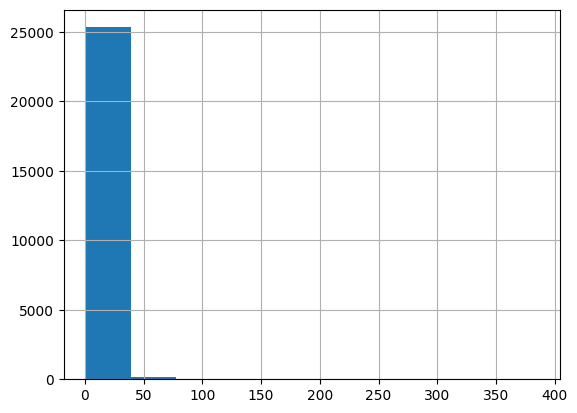

In [11]:
df_first["LastNameCount"].hist()
df_first["LastNameCount"].value_counts()

In [12]:
df_first["LastNameCount"].max(),df_last["LastNameCount"].max()

(385, 4965)

In [21]:
s = df_last[df_last["LastNameCount"] == 4965]["LastName"].iloc[0]
set(s)

{'nguyen', 'nguyyen'}

In [65]:

import recordlinkage
import pandas as pd
import re
import hashlib
from abydos.phonetic import SpanishMetaphone
from unidecode import unidecode
import networkx 
from networkx.algorithms.components.connected import connected_components
CCAI_NULL = "ccai_null"

def dedupe(id_arr,first_arr, last_arr,date_arr, email_arr, phone_arr, gender_arr):
    print("UDF called")
    if len(id_arr) == 1:
        print("UDF called 1")
        resHash = hashlib.md5(str(id_arr[0]).encode("utf-8")).hexdigest()
        return [resHash for i in range(len(id_arr))]
        # return [id_arr[0]]
    master_dict ={}
    for index, each in enumerate(id_arr):
        master_dict[each] = {
            "ProvisionalPrimaryKey":each,
            "FirstName":first_arr[index],
            "LastName":last_arr[index],
            "DateOfBirth":date_arr[index],
            # "EmailAddress":email_arr[index],
            # "Phone":phone_arr[index],
            "Gender":gender_arr[index]
        }
    
    df = pd.DataFrame(master_dict).T
    df['ProvisionalPrimaryKey'] = df['ProvisionalPrimaryKey'].fillna(CCAI_NULL)
    df['FirstName'] = df['FirstName'].fillna('FNU')
    df["Gender"] = df["Gender"].replace(0, None)
    print("UDF called 2")
    df = df.reset_index(drop=True)
    # list_of_lists = []
    df_temp_gp = df.groupby(["FirstName","LastName", "DateOfBirth"])
    list_of_lists = df_temp_gp["ProvisionalPrimaryKey"].apply(list).to_list()
    print(df_temp_gp.first().reset_index())
    df = df_temp_gp.first().reset_index() 
    df = df.replace(CCAI_NULL, None)

    if df.shape[0]>1:
        # make ProvisionalPrimaryKey as index
        df = df.set_index('ProvisionalPrimaryKey')
        df['FirstName'] = df['FirstName'].apply(lambda x: re.sub(r' jr|\.jr', ' junior alias son of '+x, x))
        df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], format='%Y-%m-%d')
        df['DateOfBirth'] = df['DateOfBirth'].dt.strftime('%Y-%m-%d')
        indexer = recordlinkage.Index()
        indexer.full()
        # indexer.add(recordlinkage.index.SortedNeighbourhood(left_on="FirstName",window=501))
        
        candidate_links = indexer.index(df)
        print ("UDF called 3",df.shape)

        compare_cl = recordlinkage.Compare(n_jobs=-1)
        compare_cl = recordlinkage.Compare()
        # compare_cl.exact("FirstName", "FirstName", label="FirstName")
        compare_cl.string("FirstName", "FirstName", method="jarowinkler", threshold=0.85, label="FirstName")
        compare_cl.string("LastName", "LastName", method="jarowinkler", threshold=0.90, label="LastName")
        compare_cl.string("DateOfBirth", "DateOfBirth", method="damerau_levenshtein", threshold=0.9, label="DateOfBirth")
        # compare_cl.date("DateOfBirth", "DateOfBirth", label="DateOfBirth",swap_month_day=1)
        # compare_cl.string("EmailAddress", "EmailAddress", label="EmailAddress", threshold=0.95)
        # compare_cl.string("Phone", "Phone", label="Phone", threshold=0.95)
        compare_cl.exact("Gender", "Gender", label="Gender")

        features = compare_cl.compute(candidate_links, df)
        print ("UDF called 4")
        df.fillna(CCAI_NULL, inplace=True)
        df = df.reset_index()
        matches_list = []
        def rule_matrix(row):
            index = row.name
            if row["FirstName"] == 1 and row["LastName"] == 1 and row["Gender"] == 1:
                if row["DateOfBirth"] == 1:
                    # matches_list.append(list(index))
                    return list(index)
                elif str(df[df["ProvisionalPrimaryKey"]== index[0]]["DateOfBirth"].values[0]) == CCAI_NULL or str(df[df["ProvisionalPrimaryKey"]== index[1]]["DateOfBirth"].values[0]) == CCAI_NULL:
                    if str(df[df["ProvisionalPrimaryKey"]== index[0]]["FirstName"].values[0]) == str(df[df["ProvisionalPrimaryKey"]== index[1]]["FirstName"].values[0]) and str(df[df["ProvisionalPrimaryKey"]== index[0]]["LastName"].values[0]) == str(df[df["ProvisionalPrimaryKey"]== index[1]]["LastName"].values[0]):
                        # matches_list.append(list(index))
                        return list(index)
            return 0
        condition1 = (features["FirstName"] == 1) & (features["LastName"] == 1) & (features["Gender"] == 1)
        features = features[condition1]
        features['ProvisionalPrimaryKey_1_main'] = features.index.get_level_values('ProvisionalPrimaryKey_1')
        features['ProvisionalPrimaryKey_2_main'] = features.index.get_level_values('ProvisionalPrimaryKey_2')
        features = features.reset_index(drop=True)
        features = features.merge(df[["ProvisionalPrimaryKey","FirstName","LastName","DateOfBirth"]],left_on ="ProvisionalPrimaryKey_1_main",right_on ="ProvisionalPrimaryKey",suffixes=[None,"_1"])
        features = features.merge(df[["ProvisionalPrimaryKey","FirstName","LastName","DateOfBirth"]],left_on ="ProvisionalPrimaryKey_2_main",right_on ="ProvisionalPrimaryKey",suffixes=[None,"_2"])
        condition2 = features["DateOfBirth"] == 1
        condition3 = (features["DateOfBirth_1"].astype(str) == CCAI_NULL) | (features["DateOfBirth_2"].astype(str) == CCAI_NULL)
        condition4 = (features["FirstName_1"].astype(str) == features["FirstName_2"].astype(str)) & (features["LastName_1"].astype(str) == features["LastName_2"].astype(str))
        features = features[condition2 | (condition3 & condition4)]
        features["combined_ProvisionalPrimaryKey"] = features[['ProvisionalPrimaryKey_1_main', 'ProvisionalPrimaryKey_2_main']].values.tolist()
        matches_list = features["combined_ProvisionalPrimaryKey"].to_list()
        print("matches list", matches_list)
        # for col in df.columns:
        #     if col in features.columns:
        #         if df[col].value_counts(normalize=True).iloc[0] >= 0.8:
        #             features = features.drop(col, axis=1)
                
        # print(features.columns)
        # print(features)
        # print("threshold", features.shape[1]*0.72)
        # matches = features[features.sum(axis=1) >= features.shape[1]*0.72]
        # matches_list = matches.index.tolist()
        # matches_list = [list(x) for x in matches_list]
        matches_list = matches_list + list_of_lists
    else:
        print("else")
        matches_list = list_of_lists
    print("UDF apply")
    print(matches_list)
    def to_graph(l):
        G = networkx.Graph()
        for part in l:
            # each sublist is a bunch of nodes
            G.add_nodes_from(part)
            # it also imlies a number of edges:
            G.add_edges_from(to_edges(part))
        return G

    def to_edges(l):
        """ 
            treat `l` as a Graph and returns it's edges 
            to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
        """
        it = iter(l)
        last = next(it)

        for current in it:
            yield last, current
            last = current    

    G = to_graph(matches_list)
    print("G",G)
    cluster = [list(x) for x in list(connected_components(G))]
    print ("UDF called 5")
    cluster_dict = {}
    for ind,each in enumerate(cluster):
        for each_element in each:
            cluster_dict[each_element] = each[0]
    print(cluster)
    return_hash_arr = []
    for i in range(len(id_arr)):
        if id_arr[i] in cluster_dict:
            return_hash_arr.append(hashlib.md5(str(cluster_dict[id_arr[i]]).encode("utf-8")).hexdigest())
        else:
            return_hash_arr.append(hashlib.md5(str(id_arr[i]).encode("utf-8")).hexdigest())

        # bool_check = False
        # for each in cluster:
        #     if id_arr[i] in each:
        #         return_hash_arr.append(hashlib.md5(str(each[0]).encode("utf-8")).hexdigest())
        #         # return_hash_arr.append(each[0])
        #         bool_check = True
        #         break
        # if bool_check == False:
        #     return_hash_arr.append(hashlib.md5(str(id_arr[i]).encode("utf-8")).hexdigest())
            # return_hash_arr.append(id_arr[i])
    print ("UDF called 6")
    return return_hash_arr
# id_arr,first_arr, last_arr,date_arr, email_arr, phone_arr, gender_arr

# df_last[df_last["LastNameCount"] == 4965]["LastName"].iloc[0]
len(dedupe(df_last[df_last["LastNameCount"] == 4965]["PassengerID"].to_list()[0],df_last[df_last["LastNameCount"] == 4965]["FirstName"].to_list()[0],df_last[df_last["LastNameCount"] == 4965]["LastName"].to_list()[0],df_last[df_last["LastNameCount"] == 4965]["DateOfBirth"].to_list()[0],df_last[df_last["LastNameCount"] == 4965]["EmailAddress"].to_list()[0],df_last[df_last["LastNameCount"] == 4965]["Phone"].to_list()[0],df_last[df_last["LastNameCount"] == 4965]["Gender"].to_list()[0]))
# len(dedupe(df_last[df_last["LastNameCount"] == 1182]["PassengerID"].to_list()[0],df_last[df_last["LastNameCount"] == 1182]["FirstName"].to_list()[0],df_last[df_last["LastNameCount"] == 1182]["LastName"].to_list()[0],df_last[df_last["LastNameCount"] == 1182]["DateOfBirth"].to_list()[0],df_last[df_last["LastNameCount"] == 1182]["EmailAddress"].to_list()[0],df_last[df_last["LastNameCount"] == 1182]["Phone"].to_list()[0],df_last[df_last["LastNameCount"] == 1182]["Gender"].to_list()[0]))

UDF called
UDF called 2
           FirstName LastName DateOfBirth ProvisionalPrimaryKey Gender
0                thi   nguyen  1957-01-25             335101421      2
1                thi   nguyen  1966-03-10             337214671      1
2                thi   nguyen  1986-09-05             333126412      1
3                thi   nguyen  1990-10-19             335343889      2
4                thi   nguyen  1990-12-28             332744153      2
...              ...      ...         ...                   ...    ...
2988     thi yen nhi   nguyen  2004-12-23             340945308      2
2989  thi yen phuong   nguyen  1999-09-10             335070443      2
2990  thi yen phuong   nguyen  1999-12-10             326045068      2
2991   thi yen thanh   nguyen  1992-06-05             331785159      2
2992     thi yen tho   nguyen  1990-12-26             327868025      2

[2993 rows x 5 columns]
UDF called 3 (2993, 4)
UDF called 4
matches list [['346027138', '335101421'], ['346027138', '335343

4965

In [47]:
df_ = pd.DataFrame([[4, 9]] * 3, columns=['A', 'B'])

def dummy_(row):
    print(row)
    print(row.name)
    return 0
import multiprocessing as mp

with mp.Pool(mp.cpu_count()) as pool:
    pool.map(dummy_, df_)
# df_.apply(dummy_, axis=1)

KeyboardInterrupt: 

In [22]:
df_last[df_last["LastNameCount"] != 4965]["LastNameCount"].max()


1182

In [62]:
df_last_1 = pd.read_parquet("dedup_debug/newlast.snappy.parquet")
df_last_1["LastNameCount"].max()

4965

1      9955
2      5008
3      2894
4      1857
5      1334
       ... 
254       1
65        1
93        1
98        1
94        1
Name: LastNameCount, Length: 120, dtype: int64

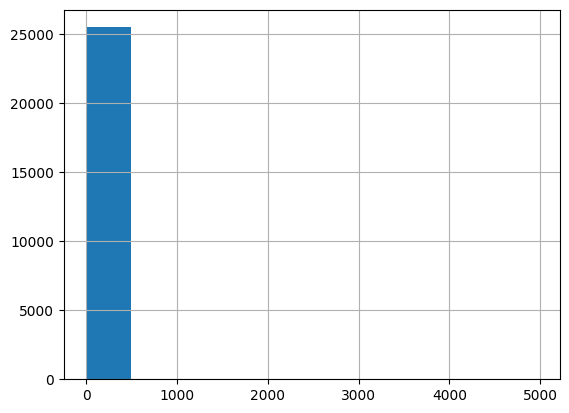

In [10]:
df_last["LastNameCount"].hist()
df_last["LastNameCount"].value_counts()

In [1]:
import fastavro

with open('person.d20220802.t051018.r1752..avro', 'rb') as avro_file:
    avro_reader = fastavro.reader(avro_file)
    for record in avro_reader:
        print(record)

{'rowid': '19930054546254763_628f7160-c335-4d91-93f6-69565dc2ecce', 'filename': 'Person.D20220802.T051018.R1752', 'vds': '2022-08-02', 'c_journaltime': '2022-08-01 20:55:14.457', 'c_transactionid': '1', 'c_operationtype': 'I', 'c_userid': 'cebu_extractor', 'personid': 10481543, 'createduserid': 8479784, 'createdutc': '2022-08-01 20:50:38.137', 'modifieduserid': 8479784, 'modifiedutc': '2022-08-01 20:50:39.697', 'persontype': 1, 'status': 1, 'culturecode': 'en-US', 'currencycode': None, 'dob': '9999-12-31', 'gender': 0, 'nationalidnumber': None, 'typebaddress': None, 'customernumber': '6840104160', 'trustlevel': 0, 'paxtype': None, 'nationality': '  ', 'residentcountry': '  ', 'notificationpreference': 0}
{'rowid': '19930054546272023_f319d8dc-900f-4148-94d2-212af7d1206d', 'filename': 'Person.D20220802.T051018.R1752', 'vds': '2022-08-02', 'c_journaltime': '2022-08-01 20:55:37.820', 'c_transactionid': '1', 'c_operationtype': 'I', 'c_userid': 'cebu_extractor', 'personid': 10481544, 'create

In [ ]:
import sys
from awsglue.transforms import Join
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job
sc = SparkContext.getOrCreate()

glueContext = GlueContext(sc)
# get spark session
spark = glueContext.spark_session
spark.conf.set("spark.sql.mapKeyDedupPolicy", "LAST_WIN")


In [1]:
# initiate pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = SparkSession.builder.appName('customer360.ai').getOrCreate()

# initiate spark context
sc = spark.sparkContext
spark.conf.set("spark.sql.mapKeyDedupPolicy", "LAST_WIN")


Picked up JAVA_TOOL_OPTIONS:  -Xmx3489m
Picked up JAVA_TOOL_OPTIONS:  -Xmx3489m


23/01/03 07:55:23 WARN Utils: Your hostname, mindgraphin-cebucdppysp-sbb545trf1u resolves to a loopback address: 127.0.0.1; using 10.0.5.2 instead (on interface ceth0)
23/01/03 07:55:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/03 07:55:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import json
# read json file
with open('profile_config_cebu_v1_dev.json') as f:
    json_data = json.load(f)

In [6]:
df_transa = spark.createDataFrame([(111, 'p', True), (111, 'p', False), (111, 'q', False), (222, 'q',True), (222, 'r', False), (222, 'p', False)], ["col1", "col2", "col3"])
df_transa.createOrReplaceTempView("df_transa")
df_transa = spark.sql("select * from df_transa where col3 = 1")
df_transa.show()

+----+----+----+
|col1|col2|col3|
+----+----+----+
| 111|   p|true|
| 222|   q|true|
+----+----+----+



In [33]:
df_transa = spark.createDataFrame([(111, 'p', 8), (111, 'q', 9), (111, 'r', 10), (222, 'q',8), (222, 'r', 19), (222, 'p', 10)], ["col1", "col2", "col3"])
df_transa.createOrReplaceTempView("df_transa")
# groub by col1 and concat col2 values sorted by col3 
df_transa = spark.sql("select * from df_transa order by col1, col3")
df_transa.show()

df_transa.createOrReplaceTempView("df_transa")

df_transa = spark.sql("SELECT col1, CONCAT_WS('_',COLLECT_LIST(col2)) AS col2 FROM df_transa GROUP BY col1")


df_tran = spark.createDataFrame([(111, 'p', 8), (111, 'q', 9), (111, 'r', 10), (222, 'q',8), (222, 'r', 19), (222, 'p', 10)], ["PassengerID", "ArrivalStation", "JourneyNumber"])
df_tran.createOrReplaceTempView("all_passengerjourneysegment")
# df_tran = spark.sql("SELECT all_passengerjourneysegment.all_passengerjourneysegment_PassengerID AS GetTravelDestination_all_passengerjourneysegment_PassengerID, all_passengerjourneysegment.all_passengerjourneysegment_ArrivalStation AS GetTravelDestination_all_passengerjourneysegment_ArrivalStation FROM ( SELECT all_passengerjourneysegment_PassengerID, max(all_passengerjourneysegment_JourneyNumber) AS all_passengerjourneysegment_maxJourneyNumber FROM all_passengerjourneysegment GROUP BY all_passengerjourneysegment_PassengerID ) AS all_passengerjourneysegment_max JOIN all_passengerjourneysegment ON all_passengerjourneysegment_max.all_passengerjourneysegment_PassengerID = all_passengerjourneysegment.all_passengerjourneysegment_PassengerID AND all_passengerjourneysegment_max.all_passengerjourneysegment_maxJourneyNumber = all_passengerjourneysegment.all_passengerjourneysegment_JourneyNumber")
df_tran = spark.sql("SELECT all_passengerjourneysegment.PassengerID AS PassengerID, all_passengerjourneysegment.ArrivalStation AS ArrivalStation FROM ( SELECT PassengerID, max(JourneyNumber) AS maxJourneyNumber FROM all_passengerjourneysegment GROUP BY PassengerID ) AS all_passengerjourneysegment_max JOIN all_passengerjourneysegment ON all_passengerjourneysegment_max.PassengerID = all_passengerjourneysegment.PassengerID AND all_passengerjourneysegment_max.maxJourneyNumber = all_passengerjourneysegment.JourneyNumber")

df_tran.show()

df_tra = spark.createDataFrame([(111,"P", 'p', 8), (111,"P", 'q', 9), (111,"P", 'r', 10), (222,"P", 'q',8), (222,"P", 'r', 19), (222,"P", 'p', 10)], ["PassengerID","DocTypeCode", "IssuedByCode", "ExpirationDate"])
df_tra.createOrReplaceTempView("all_passengertraveldoc")
# df_tra = spark.sql("SELECT all_passengertraveldoc.PassengerID AS PassengerID, all_passengertraveldoc.DocNumber AS DocNumber, all_passengertraveldoc.IssuedByCode AS IssuedByCode, all_passengertraveldoc.ExpirationDate AS ExpirationDate FROM all_passengertraveldoc WHERE upper(all_passengertraveldoc.DocTypeCode) = 'P' AND (all_passengertraveldoc.PassengerID, all_passengertraveldoc.ExpirationDate) IN ( SELECT all_passengertraveldoc.PassengerID AS PassengerID, max(all_passengertraveldoc.ExpirationDate) AS maxExpirationDate FROM all_passengertraveldoc GROUP BY all_passengertraveldoc.PassengerID )")
df_tra = spark.sql("SELECT all_passengertraveldoc.PassengerID AS PassengerID,  all_passengertraveldoc.IssuedByCode AS IssuedByCode, all_passengertraveldoc.ExpirationDate AS ExpirationDate FROM all_passengertraveldoc WHERE upper(all_passengertraveldoc.DocTypeCode) = 'P' AND (all_passengertraveldoc.PassengerID, all_passengertraveldoc.ExpirationDate) IN ( SELECT all_passengertraveldoc.PassengerID AS PassengerID, max(all_passengertraveldoc.ExpirationDate) AS maxExpirationDate FROM all_passengertraveldoc GROUP BY all_passengertraveldoc.PassengerID )")
df_tra.show()

df_joined = spark.sql("select all_passengerjourneysegment.PassengerID,all_passengerjourneysegment.ArrivalStation,all_passengertraveldoc.IssuedByCode from all_passengerjourneysegment join all_passengertraveldoc on all_passengerjourneysegment.PassengerID = all_passengertraveldoc.PassengerID").drop("PassengerID")
df_joined.show()

+----+----+----+
|col1|col2|col3|
+----+----+----+
| 111|   p|   8|
| 111|   q|   9|
| 111|   r|  10|
| 222|   q|   8|
| 222|   p|  10|
| 222|   r|  19|
+----+----+----+

+-----------+--------------+
|PassengerID|ArrivalStation|
+-----------+--------------+
|        111|             r|
|        222|             r|
+-----------+--------------+

+-----------+------------+--------------+
|PassengerID|IssuedByCode|ExpirationDate|
+-----------+------------+--------------+
|        111|           r|            10|
|        222|           r|            19|
+-----------+------------+--------------+

+--------------+------------+
|ArrivalStation|IssuedByCode|
+--------------+------------+
|             p|           p|
|             p|           q|
|             p|           r|
|             q|           p|
|             q|           q|
|             q|           r|
|             r|           p|
|             r|           q|
|             r|           r|
|             q|           q|
|          

In [77]:
df_transactional = spark.createDataFrame([(111, 'p', 3), (111, 'p', 6), (111, 'q', None), (222, 'q', 9), (222, 'r', 2), (222, 'p', 9),(333, None, None)], ["col1", "col2", "col3"])
df_transactional.createOrReplaceTempView("df_transactional")
# fill null values with ccainullplaceholder for all columns except col1
df_transactional = df_transactional.fillna("ccainullplaceholder", subset=list(df_transactional.columns).remove("col1"))
df_transactional = df_transactional.fillna(0, subset=list(df_transactional.columns).remove("col1"))
# fill null with inf for col3
df_transactional.createOrReplaceTempView("df_transactional")

df_transactional.show() 
from pyspark.sql.window import Window
# groupby col1 and create arrays for col2 and col3 and leave all other columns as is

# df_transactional = df_transactional.groupBy("col1").agg(F.collect_list("col2").alias("k"), F.collect_list("col3").alias("v"))
# convert to sql logic and alias the result
df_transactional = spark.sql("select col1, collect_list(col2) as k, collect_list(col3) as v from df_transactional group by col1")
df_transactional.show()
df_transactional.createOrReplaceTempView("df_transactional")


# set spark.sql.mapKeyDedupPolicy to LAST_WIN
spark.conf.set("spark.sql.mapKeyDedupPolicy", "LAST_WIN")
# concat col4 values into a single map
# df_transactional = df_transactional.select('col1',F.map_from_arrays(df_transactional.k, df_transactional.v).alias("map"))
# convert to sql logic
df_transactional = spark.sql("select col1, map_from_arrays(k, v) as map from df_transactional")
df_transactional.show()
# df_transactional.write.parquet("df_transactional.parquet")

# df_transactional = df_transactional.withColumn("col5", F.when(F.col("map").getItem("r").isNotNull(), F.col("map").getItem("r")).otherwise(F.lit(None)))
df_transactional.createOrReplaceTempView("df_transactional")
df_transactional = spark.sql("SELECT col1, map, CASE WHEN map['r'] IS NOT NULL THEN map['r'] ELSE 999 END AS col5 FROM df_transactional")
# df_transactional = spark.sql("SELECT col1, map, CASE WHEN map['r'] IS NOT NULL THEN map['r'] when map['q'] is not null then map['q'] ELSE 999 END AS col5 FROM df_transactional")

df_transactional.show()


df_transactional.createOrReplaceTempView("df_transactional")
# get any first key from the map and assign it to col6 column
df_transactional = spark.sql("SELECT col1, map[map_keys(map)[0]] AS col6 FROM df_transactional")
df_transactional.show()
print("||")
# replace inf with null
df_transactional = df_transactional.replace(0, None).replace("ccainullplaceholder", None)
df_transactional.show()

+----+-------------------+----+
|col1|               col2|col3|
+----+-------------------+----+
| 111|                  p|   3|
| 111|                  p|   6|
| 111|                  q|   0|
| 222|                  q|   9|
| 222|                  r|   2|
| 222|                  p|   9|
| 333|ccainullplaceholder|   0|
+----+-------------------+----+

+----+--------------------+---------+
|col1|                   k|        v|
+----+--------------------+---------+
| 111|           [p, p, q]|[3, 6, 0]|
| 222|           [q, r, p]|[9, 2, 9]|
| 333|[ccainullplacehol...|      [0]|
+----+--------------------+---------+

+----+--------------------+
|col1|                 map|
+----+--------------------+
| 111|    {p -> 6, q -> 0}|
| 222|{q -> 9, r -> 2, ...|
| 333|{ccainullplacehol...|
+----+--------------------+

+----+--------------------+----+
|col1|                 map|col5|
+----+--------------------+----+
| 111|    {p -> 6, q -> 0}| 999|
| 222|{q -> 9, r -> 2, ...|   2|
| 333|{ccainullpla

In [23]:
df = spark.sql("SELECT array(struct(1, 'a'), struct(2, 'b')) as data")
# df.select(F.map_from_arrays(df.k, df.v).alias("map")).show()
df.show()

+----------------+
|            data|
+----------------+
|[{1, a}, {2, b}]|
+----------------+



In [38]:
df = spark.sql("SELECT array(struct(1, 'a'), struct(2, 'b')) as data")
df.show()

+----------------+
|            data|
+----------------+
|[{1, a}, {2, b}]|
+----------------+



In [36]:
from pyspark.sql.functions import map_from_entries
df = spark.sql("SELECT array(map(1, 'a'), map(2, NULL)) as data")
# df = spark.sql("SELECT map(1, 'a', 2, 'b') as data")
df.show()
df.select(map_from_entries("data").alias("map")).show()


+--------------------+
|                data|
+--------------------+
|[{1 -> a}, {2 -> ...|
+--------------------+



AnalysisException: cannot resolve 'map_from_entries(data)' due to data type mismatch: 'data' is of array<map<int,string>> type. map_from_entries accepts only arrays of pair structs.;
'Project [map_from_entries(data#567) AS map#574]
+- Project [array(map(1, a), cast(map(2, null) as map<int,string>)) AS data#567]
   +- OneRowRelation


In [40]:
df_transactional = spark.createDataFrame([(111, 'p', 3), (111, 'p', 6), (111, 'q', None), (222, 'q', 9), (222, 'r', 2), (222, 'p', 9),(333, 'p', None)], ["col1", "col2", "col3"])
df_transactional.createOrReplaceTempView("df_transactional")
df_transactional = spark.sql("select col1, struct(col2, col3) as k from df_transactional")
# df_transactional = df_transactional.select(["col1",F.create_map("col2","col3").alias("k")])

# groupby col1 and create arrays for col2 and col3 and leave all other columns as is
df_transactional = df_transactional.groupBy("col1").agg(F.collect_list("k").alias("k"))
# make single map from the array of maps in k
df_transactional = df_transactional.select(F.map_from_entries("k").alias("map"))
df_transactional.show()

+--------------------+
|                 map|
+--------------------+
| {p -> 6, q -> null}|
|{q -> 9, r -> 2, ...|
|         {p -> null}|
+--------------------+



In [64]:
df_v = spark.read.parquet("yesssssssssssssssssssssss.snappy.parquet")
# get column all_person_Number
df_v.createOrReplaceTempView("df_v")
df_v = spark.sql("SELECT all_personphone_PersonID FROM df_v")
df_v = spark.sql("SELECT all_bookingcontact_LastName FROM df_v")
# df_v = spark.sql("SELECT all_bookingpassenger_PassengerID FROM df_v")
df_v.show()

+---------------------------+
|all_bookingcontact_LastName|
+---------------------------+
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|                       null|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
|            {[P] -> [xxxx]}|
+---------------------------+
only showing top 20 rows



In [32]:
",".join(["a","b","c"])

'a,b,c'

In [ ]:
import sys
from awsglue.transforms import Join
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job
import py4j
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, LongType, DoubleType, BooleanType, DateType, TimestampType
import boto3
import json

sc = SparkContext.getOrCreate()

glueContext = GlueContext(sc)
# get spark session
spark = glueContext.spark_session
spark.conf.set("spark.sql.mapKeyDedupPolicy", "LAST_WIN")
log4jLogger = sc._jvm.org.apache.log4j

LOGGER = log4jLogger.LogManager.getLogger(__name__)


In [ ]:
def get_config(file_path):
    # file_path = "s3a://cebu-cdp-data-qa/script/glue/cebu-cdp-profile-glue/profile_config_cebu_v1.json"
    bucket_name = file_path.split('/')[2]
    key = '/'.join(file_path.split('/')[3:])
    s3 = boto3.client('s3')
    return json.loads(s3.get_object(Bucket=bucket_name, Key=key)['Body'].read())


def get_latest_partition(path, key):
    # initiate s3 client
    s3 = boto3.client('s3')
    # get bucket name and prefix
    bucket_name = path.split('/')[2]
    prefix = '/'.join(path.split('/')[3:]) + '/'
    # bucket_name = 'edw-dl-process-data-dev'
    # prefix = 'data/odstest/hdata/odstest_all_diffen_open/odstest_all_booking/'
    # get all sub folfers names in the path
    response = s3.list_objects_v2(
        Bucket=bucket_name, Prefix=prefix, Delimiter='/')

    dates = []
    for page in response['CommonPrefixes']:
        if key[0] in page['Prefix'].split('/')[-2]:
            dates.append(page['Prefix'].split('/')[-2])
    # sort dates in descending order
    dates.sort(reverse=True)
    return dates[0]


def filter_tables(config, source_dict):
    filter_arr = {
        "all_bookingcontact": "TypeCode = 'P' or TypeCode = 'W'",
        "all_passengertraveldoc": "DocTypeCode = 'OAFF' or DocTypeCode = 'S' or DocTypeCode = 'P' or DocTypeCode = 'CEB'",
        "all_passengerfee": "FeeCode = 'BAG10' or FeeCode = 'BAG15' or FeeCode = 'BAG20' or FeeCode = 'BAG25' or FeeCode = 'BAG30' or FeeCode = 'BAG32' or FeeCode = 'BAG35' or FeeCode = 'BAG40' or FeeCode = 'BAG45' or FeeCode = 'MEAL' or FeeCode = 'MEAL1' or FeeCode = 'MEAL2' or FeeCode = 'MEAL3' or FeeCode = 'MEAL4' or FeeCode = 'MEAL5' or FeeCode = 'NSURAD' or FeeCode = 'NSURAR' or FeeCode = 'NSURCD' or FeeCode = 'NSURCR' or FeeCode = 'NSURIN' or FeeCode = 'NSURIR' or FeeCode = 'ININF2' or FeeCode = 'ININFO' or FeeCode = 'ININFR' or FeeCode = 'INS' or FeeCode = 'INSCDO' or FeeCode = 'INSCDR' or FeeCode = 'INSLH1' or FeeCode = 'INSLH2' or FeeCode = 'INSOW' or FeeCode = 'INSRT' or FeeCode = 'INSRT2'",
        "all_personname": "NameType = 1",
        "all_personemail": "IsDefault = 1",
        "all_traveldoc": "DocTypeCode = 'OAFF' or DocTypeCode = 'S' or DocTypeCode = 'P' or DocTypeCode = 'CEB' or DocTypeCode = 'GG'",
        "all_personaddress": "IsDefault = 1",
        "all_personphone": "IsDefault = 1 AND (TypeCode = 'M' OR TypeCode = 'H')"
    }
    for each_source in config['entityDetails']:
        if each_source['entityName'] in filter_arr:
            source_dict[each_source['entityName']] = source_dict[each_source['entityName']].filter(
                filter_arr[each_source['entityName']])
    return source_dict


def get_columns_list(config):
    column_list = {}
    for eachMapping in config['attributeMapping']:
        for eachSourceMapping in eachMapping['sourceColumns']:
            if eachSourceMapping['entityName'] in column_list:
                column_list[eachSourceMapping['entityName']].append(
                    eachSourceMapping['columnName'])
            else:
                column_list[eachSourceMapping['entityName']] = [
                    eachSourceMapping['columnName']]
    for eachMapping in config['columnMapping']:
        column_list[eachMapping['sourceEntity']].append(
            eachMapping['sourceColumn'])
    # apply distinct on each list
    for eachColumnList in column_list:
        column_list[eachColumnList] = list(set(column_list[eachColumnList]))
    return column_list

def load_data(config):
    column_list = get_columns_list(config)
    source_dict = {}
    for each_source in config['entityDetails']:
        if each_source['entityType'] == 'snapshot':
            # get latest partition
            latest_partition = get_latest_partition(
                each_source['pathUrl'], each_source['partitionDetails']['partitionColumn'])
            # read orc data using spark
            source_dict[each_source['entityName']] = spark.read.load(
                each_source['pathUrl'] + "/" + latest_partition, format=each_source['dataFormat'], header=True).select(column_list[each_source['entityName']])
    source_dict = filter_tables(config, source_dict)
    return source_dict


def derived_tables(config, source_dict):
    derive_dict = {
        "all_passengerjourneyleg": ["select * from all_passengerjourneyleg order by PassengerID, ModifiedUTC desc", "SELECT PassengerID, CONCAT_WS('_',COLLECT_LIST(UnitDesignator)) AS UnitDesignator FROM all_passengerjourneyleg GROUP BY PassengerID"],
        "GetTravelDestination_all_passengerjourneysegment": ["SELECT all_passengerjourneysegment.PassengerID AS PassengerID, all_passengerjourneysegment.ArrivalStation AS ArrivalStation FROM ( SELECT PassengerID, max(JourneyNumber) AS maxJourneyNumber FROM all_passengerjourneysegment GROUP BY PassengerID ) AS all_passengerjourneysegment_max JOIN all_passengerjourneysegment ON all_passengerjourneysegment_max.PassengerID = all_passengerjourneysegment.PassengerID AND all_passengerjourneysegment_max.maxJourneyNumber = all_passengerjourneysegment.JourneyNumber"],
        "GetPassportNumber_all_passengertraveldoc": ["SELECT all_passengertraveldoc.PassengerID AS PassengerID, all_passengertraveldoc.DocNumber AS DocNumber, all_passengertraveldoc.IssuedByCode AS IssuedByCode, all_passengertraveldoc.ExpirationDate AS ExpirationDate FROM all_passengertraveldoc WHERE upper(all_passengertraveldoc.DocTypeCode) = 'P' AND (all_passengertraveldoc.PassengerID, all_passengertraveldoc.ExpirationDate) IN ( SELECT all_passengertraveldoc.PassengerID AS PassengerID, max(all_passengertraveldoc.ExpirationDate) AS maxExpirationDate FROM all_passengertraveldoc GROUP BY all_passengertraveldoc.PassengerID )"],
        "GetPassportNumber_all_traveldoc": ["SELECT all_traveldoc.PersonID AS PersonID, all_traveldoc.DocNumber AS DocNumber, all_traveldoc.IssuedByCode AS IssuedByCode, all_traveldoc.ExpirationDate AS ExpirationDate FROM all_traveldoc WHERE upper(all_traveldoc.DocTypeCode) = 'P' AND (all_traveldoc.PersonID, all_traveldoc.ExpirationDate) IN ( SELECT all_traveldoc.PersonID AS PersonID, max(all_traveldoc.ExpirationDate) AS maxExpirationDate FROM all_traveldoc GROUP BY all_traveldoc.PersonID)"],        
        "all_passengerfee": ["select all_passengerfee.PassengerID,all_passengerfee.FeeCode, all_fee.Name from all_passengerfee left join all_fee on all_passengerfee.FeeCode = all_fee.FeeCode"],
        "all_passengerjourneysegment": ["select * from all_passengerjourneysegment where JourneyNumber = 1"],
        "GetTravelSoloOrGroup_all_bookingpassenger": ["select BookingID, case when count(distinct PassengerID) > 1 then 'Group' else 'Solo' end as TravelSoloOrGroup from all_bookingpassenger group by BookingID"]
    }
    mask_sources = ["all_fee"]
    # create temp tables for all sources
    for each_source in source_dict:
        source_dict[each_source].createOrReplaceTempView(each_source)
    # create derived tables
    for each_derived in derive_dict:
        for each_tran in derive_dict[each_derived]:
            source_dict[each_derived] = spark.sql(each_tran)
            source_dict[each_derived].createOrReplaceTempView(each_derived)
    # mask/remove tables
    for each_mask in mask_sources:
        source_dict.pop(each_mask)
    return source_dict


def transaction_conversion(config, source_dict):
    transaction_dict = {
        "all_bookingcontact": {
            "key": "BookingID",
            "mapColumn": "TypeCode"
        },
        "all_passengertraveldoc": {
            "key": "PassengerID",
            "mapColumn": "DocTypeCode"
        },
        "all_passengerfee": {
            "key": "PassengerID",
            "mapColumn": "FeeCode"
        },
        "all_traveldoc": {
            "key": "PersonID",
            "mapColumn": "DocTypeCode"
        },
        "all_personphone": {
            "key": "PersonID",
            "mapColumn": "TypeCode"
        }
    }
    column_list = get_columns_list(config)
    for each_source in transaction_dict:
        source_dict[each_source].createOrReplaceTempView(each_source)
        # building query select col1, collect_list(col2) as k, collect_list(col3) as v from df_transactional group by col1
        query = "select " + transaction_dict[each_source]['key']
        for each_column in column_list[each_source]:
            if each_column != transaction_dict[each_source]['key']:
                query += ", collect_list(" + each_column + \
                    ") as " + each_column
        query += " from " + each_source + " group by " + \
            transaction_dict[each_source]['key']
        source_dict[each_source] = spark.sql(query)
        source_dict[each_source].createOrReplaceTempView(each_source)
        # building query select col1, map(col2, col3) as k, map(col4, col5) as v from df_transactional
        query = "select " + transaction_dict[each_source]['key']
        for each_column in column_list[each_source]:
            if each_column != transaction_dict[each_source]['key'] and each_column != transaction_dict[each_source]['mapColumn']:
                query += ", map(" + transaction_dict[each_source]['mapColumn'] + \
                    ", " + each_column + ") as " + each_column
        query += " from " + each_source
        source_dict[each_source] = spark.sql(query)
        source_dict[each_source].createOrReplaceTempView(each_source)
    return source_dict


def join_entities(config, source_dict):
    join_dict = {
        "all_bookingpassenger": {
            "all_booking": "BookingID",
            "all_bookingcontact": "BookingID",
            "GetTravelSoloOrGroup_all_bookingpassenger": "BookingID",
            "all_passengeraddress": "PassengerID",
            "all_passengertraveldoc": "PassengerID",
            "all_passengerjourneysegment": "PassengerID",
            "all_passengerjourneyleg": "PassengerID",
            "GetTravelDestination_all_passengerjourneysegment": "PassengerID",
            "GetPassportNumber_all_passengertraveldoc": "PassengerID",
            "all_passengerfee": "PassengerID"
        },
        "all_person": {
            "all_personname": "PersonID",
            "all_personemail": "PersonID",
            "all_personphone": "PersonID",
            "all_personaddress": "PersonID",
            "all_traveldoc": "PersonID",
            "GetPassportNumber_all_traveldoc": "PersonID",
            "all_agent" : "PersonID"
        }
    }
    master_tables = {}
    for each_master in join_dict:
        master_tables[each_master] = source_dict[each_master].select([F.col(each_column).alias(
            each_master + "_" + each_column) for each_column in source_dict[each_master].columns])
        for each_source in join_dict[each_master]:
            source_dict[each_source] = source_dict[each_source].select([F.col(each_column).alias(
                each_source + "_" + each_column) for each_column in source_dict[each_source].columns])
            # join master table with each source on join_dict[each_master][each_source]
            master_tables[each_master] = master_tables[each_master].join(
                source_dict[each_source], master_tables[each_master][each_master + "_" + join_dict[each_master][each_source]] == source_dict[each_source][each_source + "_" + join_dict[each_master][each_source]], "left")
    return master_tables

def create_profile(config):
    profileSchema = []
    for each in config["profileSchema"]:
        if each['dataType'] == 'string':
            profileSchema.append(StructField(each['columnName'], StringType(), True))
        elif each['dataType'] == 'integer':
            profileSchema.append(StructField(each['columnName'], IntegerType(), True))
        elif each['dataType'] == 'long':
            profileSchema.append(StructField(each['columnName'], LongType(), True))
        elif each['dataType'] == 'double':
            profileSchema.append(StructField(each['columnName'], DoubleType(), True))
        elif each['dataType'] == 'boolean':
            profileSchema.append(StructField(each['columnName'], BooleanType(), True))
        elif each['dataType'] == 'date':
            profileSchema.append(StructField(each['columnName'], DateType(), True))

    profileSchema = StructType(profileSchema)
    profile_df = spark.createDataFrame([], profileSchema)
    return profile_df
def master_profile_merge(config, profile_df, master_tables, source_dict):
    # for each_master in master_tables:
        # master_tables[each_master].createOrReplaceTempView(each_master)
    # left join master_tables["all_bookingpassenger"] with profile_df
    profile_df.createOrReplaceTempView("profiles")
    master_tables["all_bookingpassenger"].createOrReplaceTempView("all_bookingpassengermaster")
    master_tables["all_person"].createOrReplaceTempView("all_personmaster")
    profile_df = spark.sql("select * from all_bookingpassengermaster left join profiles on all_bookingpassengermaster.all_bookingpassenger_PassengerID = profiles.PassengerID")
    profile_df.createOrReplaceTempView("profiles")
    # outer join profiles with all_personmaster on all_personmaster.all_agent_AgentID = profiles.all_booking_CreatedUserID
    profile_df = spark.sql("select * from profiles full outer join all_personmaster on all_personmaster.all_agent_AgentID = profiles.all_booking_CreatedUserID")
    
    profile_df.createOrReplaceTempView("profiles")
    return profile_df

def populate_direct_copy_columns(config, profile_df):
    for each_column in config["columnMapping"]:
        # each_column: {'sourceEntity': 'all_bookingpassenger', 'sourceColumn': 'PassengerID', 'targetColumn': 'PassengerID'}
        # copy each_column['sourceEntity']_each_column['sourceColumn'] to profile_df[each_column['targetColumn']]
        profile_df = profile_df.withColumn(each_column['targetColumn'], F.col(each_column['sourceEntity'] + "_" + each_column['sourceColumn']))
    return profile_df

def transformations(config, profile_df):
    for each_transformation in config["attributeMapping"]:
        # each_transformation: {'targetColumn': '
        print(each_transformation)
    return profile_df
def main():
    config = get_config(
        "s3a://cebu-cdp-data-qa/script/glue/cebu-cdp-profile-glue/profile_config_cebu_v1.json")
    source_dict = load_data(config)
    LOGGER.info("CCAI - data loading complete")
    source_dict = derived_tables(config, source_dict)
    LOGGER.info("CCAI - derived tables complete")
    source_dict = transaction_conversion(config, source_dict)
    LOGGER.info("CCAI - transaction conversion complete")
    master_tables = join_entities(config, source_dict)
    LOGGER.info("CCAI - join entities complete")
    # for each_master in master_tables:
        # master_tables[each_master].write.mode("overwrite").parquet(
            # "s3a://cebu-cdp-data-qa/ccai_" + each_master)
    profile_df = create_profile(config)
    temp = profile_df.take(1)
    LOGGER.info("CCAI - profile creation complete")
    profile_df = master_profile_merge(config, profile_df, master_tables, source_dict)
    temp = profile_df.take(1)
    LOGGER.info("CCAI - master profile merge complete")
    profile_df = populate_direct_copy_columns(config, profile_df)
    temp = profile_df.take(1)
    LOGGER.info("CCAI - populate direct copy columns complete")
    profile_df.write.mode("overwrite").parquet("s3a://cebu-cdp-data-qa/ccai_profiles")

main()


In [5]:
# print keys
for each_source in json_data:
    print(each_source)
# json_data

entityDetails
profileSchema
columnMapping
attributeMapping
storageDetails


In [41]:
def get_columns_list(config):
    column_list = {}
    for eachMapping in config['attributeMapping']:
        for eachSourceMapping in eachMapping['sourceColumns']:
            if eachSourceMapping['entityName'] in column_list:
                column_list[eachSourceMapping['entityName']].append(
                    eachSourceMapping['columnName'])
            else:
                column_list[eachSourceMapping['entityName']] = [
                    eachSourceMapping['columnName']]
    for eachMapping in config['columnMapping']:
        column_list[eachMapping['sourceEntity']].append(
            eachMapping['sourceColumn'])
    # apply distinct on each list
    for eachColumnList in column_list:
        column_list[eachColumnList] = list(set(column_list[eachColumnList]))
    return column_list
get_columns_list(json_data)

{'all_bookingpassenger': ['Gender',
  'Suffix',
  'LastName',
  'BookingID',
  'DOB',
  'TotalCost',
  'Nationality',
  'ResidentCountry',
  'MiddleName',
  'CustomerNumber',
  'Title',
  'PassengerID',
  'FirstName'],
 'all_passengertraveldoc': ['DocNumber',
  'IssuedByCode',
  'LastName',
  'ExpirationDate',
  'DocTypeCode',
  'PassengerID',
  'FirstName'],
 'all_booking': ['CurrencyCode',
  'BookingID',
  'BookingUTC',
  'ChannelType',
  'CreatedUserID'],
 'all_agent': ['AgentID', 'PersonID'],
 'all_person': ['Gender',
  'PersonType',
  'DOB',
  'PersonID',
  'Nationality',
  'ResidentCountry',
  'CustomerNumber'],
 'all_personname': ['Suffix',
  'LastName',
  'PersonID',
  'MiddleName',
  'NameType',
  'Title',
  'FirstName'],
 'all_passengeraddress': ['AddressLine1',
  'City',
  'ProvinceState',
  'EmailAddress',
  'Phone',
  'PostalCode',
  'AddressLine2',
  'PassengerID',
  'AddressLine3',
  'CountryCode'],
 'all_personemail': ['EMailAddress', 'IsDefault', 'PersonID'],
 'all_per

In [44]:
json_data['storageDetails'][0]

{'recordType': 'valid-records',
 'dataFormat': 'parquet',
 'fileSystem': 's3',
 'pathUrl': 's3a://cebu-cdp-data-dev/profiles/master/master_profile',
 'storageHandler': 'PersistHadoopFS'}

In [29]:
def get_columns_list(config):
    column_list = {}
    for eachMapping in config['attributeMapping']:
        for eachSourceMapping in eachMapping['sourceColumns']:
            if eachSourceMapping['entityName'] in column_list:
                column_list[eachSourceMapping['entityName']].append(
                    eachSourceMapping['columnName'])
            else:
                column_list[eachSourceMapping['entityName']] = [
                    eachSourceMapping['columnName']]
    # apply distinct on each list
    for eachColumnList in column_list:
        column_list[eachColumnList] = list(set(column_list[eachColumnList]))
    return column_list
get_columns_list(json_data)

{'all_bookingpassenger': ['Gender',
  'Suffix',
  'LastName',
  'BookingID',
  'DOB',
  'Nationality',
  'ResidentCountry',
  'MiddleName',
  'CustomerNumber',
  'Title',
  'PassengerID',
  'FirstName'],
 'all_passengertraveldoc': ['DocNumber',
  'IssuedByCode',
  'LastName',
  'ExpirationDate',
  'DocTypeCode',
  'PassengerID',
  'FirstName'],
 'all_booking': ['CurrencyCode',
  'BookingID',
  'BookingUTC',
  'ChannelType',
  'CreatedUserID'],
 'all_agent': ['AgentID', 'PersonID'],
 'all_person': ['Gender',
  'PersonType',
  'DOB',
  'PersonID',
  'Nationality',
  'ResidentCountry',
  'CustomerNumber'],
 'all_personname': ['Suffix',
  'LastName',
  'PersonID',
  'MiddleName',
  'NameType',
  'Title',
  'FirstName'],
 'all_passengeraddress': ['AddressLine1',
  'City',
  'ProvinceState',
  'EmailAddress',
  'Phone',
  'PostalCode',
  'AddressLine2',
  'PassengerID',
  'AddressLine3',
  'CountryCode'],
 'all_personemail': ['EMailAddress', 'IsDefault', 'PersonID'],
 'all_personphone': ['Ty

In [16]:
uniqueTypes = []
for each in json_data["profileSchema"]:
    uniqueTypes.append(each["dataType"])
list(set(uniqueTypes))

['long', 'double', 'string']

In [18]:
# create a new dataframe from a list of dicts ex. [{columnName: "Name", dataType: "String"}, {columnName: "Age", dataType: "Integer"}]
profileSchema = []
for each in json_data["profileSchema"]:
    if each['dataType'] == 'string':
        profileSchema.append(StructField(each['columnName'], StringType(), True))
    elif each['dataType'] == 'integer':
        profileSchema.append(StructField(each['columnName'], IntegerType(), True))
    elif each['dataType'] == 'long':
        profileSchema.append(StructField(each['columnName'], LongType(), True))
    elif each['dataType'] == 'double':
        profileSchema.append(StructField(each['columnName'], DoubleType(), True))
    elif each['dataType'] == 'boolean':
        profileSchema.append(StructField(each['columnName'], BooleanType(), True))
    elif each['dataType'] == 'date':
        profileSchema.append(StructField(each['columnName'], DateType(), True))

profileSchema = StructType(profileSchema)
profile_df = spark.createDataFrame([], profileSchema)
profile_df.show()
# df = spark.createDataFrame([{"columnName": "Name", "dataType": "String"}, {"columnName": "Age", "dataType": "Integer"}])

22/12/31 09:33:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------------------+-----------+-------+---------+-----------------+--------+------------+---------+----------+--------+---------------+---------------+------------+-----+----+-----+-------+-----------+-----------+------+-----------+---------------+--------------+--------------+----------+--------------+-------------+-------+---------------+---------------+------------+----------+-------------+-----------+----------+---------------+------------------+-----------+----------+---------------+----------------+--------------+------------------+-----------------+-------------------+-----------------------+------------------------+----------------------+-------------------+-----------------------+-----------------------+------------------+-------------------+---------------------+-------------------------+----------------------------+---------------------------+--------------------------+---------------------------+-------------------------+----------------------+--------------------------

In [54]:
#  travel table -> bookingid, passengerid

#  new column travelstatus -> if number of distinct passengerid for a bookingid is greater than 1
#  then travelstatus is group else it is solo

df_travel = spark.createDataFrame([(1, 1, 1), (2, 2, None), (3, 3, None), (
    4, 5, None), (5, 6, None), (6, 6, None)], ["bookingid", "passengerid", "bookerid"])
df_traveller = spark.createDataFrame([(1, 1, 1), (2, 2, None), (3, 3, None), (
    4, 5, None), (5, 6, None), (7, 6, None)], ["bookingids", "passengerids", "bookerids"])

df_travel.createOrReplaceTempView("travel")
df_traveller.createOrReplaceTempView("traveller")

df_joined = spark.sql(
    "select * from travel full outer join traveller on travel.bookingid = traveller.bookingids")
df_joined.show()
# df_travel = spark.sql(
#     "select bookingid, case when count(distinct passengerid) > 1 then 'group' else 'solo' end as TravelSoloOrGroup from travel group by bookingid;")
# df_travel.show()
# df_travel.createOrReplaceTempView("travel")


df_travel.createOrReplaceTempView("travel")
    
# df_travel = spark.sql("select  bookingid as bookerid,* from travel")
df_travel = df_travel.withColumn("bookerid",  F.col("bookingid"))
df_travel.show()


+---------+-----------+--------+----------+------------+---------+
|bookingid|passengerid|bookerid|bookingids|passengerids|bookerids|
+---------+-----------+--------+----------+------------+---------+
|        1|          1|       1|         1|           1|        1|
|        2|          2|    null|         2|           2|     null|
|        3|          3|    null|         3|           3|     null|
|        4|          5|    null|         4|           5|     null|
|        5|          6|    null|         5|           6|     null|
|        6|          6|    null|      null|        null|     null|
|     null|       null|    null|         7|           6|     null|
+---------+-----------+--------+----------+------------+---------+

+---------+-----------+--------+
|bookingid|passengerid|bookerid|
+---------+-----------+--------+
|        1|          1|       1|
|        2|          2|       2|
|        3|          3|       3|
|        4|          5|       4|
|        5|          6|       5

In [57]:
[each for each in df_travel.columns if each not in ["bookerid"]]


['bookingid', 'passengerid']

In [16]:
df_travel = spark.createDataFrame([(1, 1, 1), (2, 2, None), (3, 3, None), (
    4, 5, None), (5, 6, None), (5, 6, None)], ["bookingid", "passengerid", "bookerid"])
df_travel.createOrReplaceTempView("travel")
# get count of each distinct bookingid
# df_travel.drop()
df_travel = spark.sql(
    "select *, bookingid as bookerid from travel")

df_travel.show()

+---------+-----------+--------+--------+
|bookingid|passengerid|bookerid|bookerid|
+---------+-----------+--------+--------+
|        1|          1|       1|       1|
|        2|          2|    null|       2|
|        3|          3|    null|       3|
|        4|          5|    null|       4|
|        5|          6|    null|       5|
|        5|          6|    null|       5|
+---------+-----------+--------+--------+



In [47]:
df_travel.hint("rebalance")

+----------+------------+---------+
|lbookingid|lpassengerid|lbookerid|
+----------+------------+---------+
|         2|           2|     null|
|         3|           3|        1|
|         4|           5|     null|
|         4|           6|     null|
|         4|           7|     null|
|         5|           8|     null|
|         5|           9|     null|
|         6|          10|     null|
+----------+------------+---------+



In [16]:
df_travel.withColumn("rand", (F.rand()*2000).cast('int').cast('string')).show()

+---------+-----------+--------+----+
|bookingid|passengerid|bookerid|rand|
+---------+-----------+--------+----+
|        1|          1|       1| 998|
|        2|          2|    null|1809|
|        3|          3|    null| 104|
|        4|          5|    null| 855|
|        5|          6|    null| 615|
|        5|          6|    null|1591|
+---------+-----------+--------+----+



In [68]:
# number of partitoins of df_travel
df_travel.rdd.getNumPartitions()
# count number of rows of df_travel in each partition
temp = df_travel.rdd.mapPartitions(lambda x: [sum(1 for _ in x)]).collect()
# convert temp to string
",".join([str(each) for each in df_travel.rdd.mapPartitions(lambda x: [sum(1 for _ in x)]).collect()])

'0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1'

In [70]:
",".join([str(each) for each in df_travel.rdd.mapPartitions(lambda x: [sum(1 for _ in x)]).collect()])


'0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,1'

In [69]:
str(df_travel.rdd.getNumPartitions())


'16'

In [64]:
# get number of spark partitions
spark.conf.get("spark.sql.shuffle.partitions")

'200'

In [51]:
print(list(df_travel.columns).remove("bookerid"))
print(list(df_travel.columns))


None
['bookerid', 'bookingid', 'passengerid', 'bookerid']


In [9]:
import pyspark.pandas as ps
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, DoubleType, BooleanType, DateType, TimestampType, MapType, ArrayType,FloatType
import random
df_travel = spark.createDataFrame([(2, 2, None), (3, 3, 1), (
    4, 5, None),(4, 6, None),(4, 7, None), (5, 8, None), (5, 9, None), (6, 10, None)], ["lbookingid", "lpassengerid", "lbookerid"])

df_lugg = spark.createDataFrame([(1, 1, 1), (2, 2, 2), (3, 3, None), (4, 5, None), (5, 6, None)], ["rbookingid", "rpassengerid", "rbookerid"])


def skew_outer_join(left_df,right_df,left_join_col,right_join_col):
    def get_skewed_values(df, column_name = "all_booking_CreatedUserID"):
        df.createOrReplaceTempView("skewed_dataset")
        query = "select " + column_name + ", count(" + column_name + ") as count from skewed_dataset group by " + column_name + " order by count desc"
        df = spark.sql(query)
        # df.repartition(1).write.mode("overwrite").parquet("s3a://cebu-cdp-data-qa/bookingpassmaster")
        df = df.pandas_api()
        # sort bookingpassmaster and personmaster by count
        df = df.sort_values(by=['count'], ascending=False)
        # get top 50 all_booking_CreatedUserID as a list
        return df[column_name].head(50).to_numpy(), df[column_name].to_numpy()
    left_skewed_list, left_full_list = get_skewed_values(left_df, left_join_col)
    right_skewed_list, right_full_list = get_skewed_values(right_df, right_join_col)

    all_value_tuple = []
    for each in list(set([*left_full_list,*right_full_list])):
        all_value_tuple.append(int(each))
    print(all_value_tuple)
    # print type of left_join_col in left_df
    # print(left_df.select(left_join_col).dtypes[0][1])
    all_value_df = spark.createDataFrame(all_value_tuple, left_df.select(left_join_col).dtypes[0][1]).withColumnRenamed("value", "all_join_vals")
    # broadcast left join all_value_df with left_df with hint in sql
    all_value_df.createOrReplaceTempView("all_value_df")
    left_df.createOrReplaceTempView("left_df")
    right_df.createOrReplaceTempView("right_df")
    # broadcast left join all_value_df with left_df 
    left_df = spark.sql("select /*+ BROADCAST(all_value_df) */ all_value_df.all_join_vals, left_df.* from all_value_df left join left_df on all_value_df.all_join_vals = left_df." + left_join_col)
    # broadcast left join all_value_df with right_df with hint
    right_df = spark.sql("select /*+ BROADCAST(all_value_df) */ all_value_df.all_join_vals, right_df.* from all_value_df left join right_df on all_value_df.all_join_vals = right_df." + right_join_col)
    left_df = left_df.drop(left_join_col).withColumnRenamed("all_join_vals", left_join_col)
    right_df = right_df.drop(right_join_col).withColumnRenamed("all_join_vals", right_join_col)
    # left_df.show()
    # right_df.show()
    def left_skew_handler(x, skew_list):
        if x in skew_list:
            # add random number from 0 to 2000 to x_
            # generate random number from 0 to 2000
            return str(x) + "_" + str(random.randint(0, 2000))
        else:
            return x
    skew_handler_udf = F.udf(lambda x: left_skew_handler(x, left_skewed_list), StringType())
    left_df = left_df.withColumn(left_join_col+"_salted", skew_handler_udf(F.col(left_join_col)))
    def prep_right_df(all_list,skew_list):
        right_values = []
        print(skew_list)
        for each in all_list:
            if each in skew_list:
            # print(each)
                for i in range(2000):
                    right_values.append((int(each), str(each)+"_"+str(i)))
            else:
                right_values.append((int(each), str(each)))

        return right_values
    right_values = prep_right_df(all_value_tuple,left_skewed_list)
    right_df_join = spark.createDataFrame(right_values, [right_join_col, right_join_col+"_salted"])
    right_df_join.createOrReplaceTempView("right_df_join")
    right_df.createOrReplaceTempView("right_df")
    right_df = spark.sql("select /*+ BROADCAST(right_df_join) */ right_df_join."+right_join_col+",right_df_join."+right_join_col+"_salted, right_df.* from right_df_join left join right_df on right_df_join."+ right_join_col+" = right_df." + right_join_col)
    right_df = right_df.drop(right_df_join[right_join_col])

    # inner join left_df and right_df
    left_df.createOrReplaceTempView("left_df")
    right_df.createOrReplaceTempView("right_df")
    # left_df.show()
    # right_df.show()
    joined_df = spark.sql("select left_df.*, right_df.* from left_df inner join right_df on left_df."+ left_join_col+"_salted = right_df." + right_join_col+"_salted")
    
    # joined_df.show()
    return joined_df

joined_df = skew_outer_join(df_travel,df_lugg,"lbookingid","rbookingid")

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/workspace/.pyenv_mirror/user/current/lib/python3.8/site-pack

[1, 2, 3, 4, 5, 6]
[4 5 2 3 6]
23/01/01 19:02:31 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:31 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:32 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:32 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


23/01/01 19:02:32 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:32 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:32 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:32 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:32 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
+-----------------+----------+------------+---------+
|rbookingid_salted|rbookingid|rpassengerid|rbookerid|
+-----------------+----------+------------+---------+
|                1|         1|           1|        1|
|              2_0|         2|           2|        2|
|              2_1|         2|           2|        2|
|              2_2|         2| 

23/01/01 19:02:33 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:33 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:33 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:33 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:33 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:33 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


23/01/01 19:02:34 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:34 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:34 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:34 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:34 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:34 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


23/01/01 19:02:34 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:34 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:34 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
23/01/01 19:02:34 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
+----------+------------+---------+-----------------+-----------------+----------+------------+---------+
|lbookingid|lpassengerid|lbookerid|lbookingid_salted|rbookingid_salted|rbookingid|rpassengerid|rbookerid|
+----------+------------+---------+-----------------+-----------------+----------+------------+---------+
|         1|        null|     null|                1|                1|         1|           1|        1|
|         2|           2|     null|           2_1326|       

In [68]:
df_travel = spark.createDataFrame([(2, 2, None), (3, 3, 1), (
    4, 5, None),(4, 6, None),(4, 7, None), (5, 8, None), (5, 9, None), (6, 10, None)], ["lbookingid", "lpassengerid", "lbookerid"])
df_travel.createOrReplaceTempView("travel")
print(df_travel.rdd.getNumPartitions())
df_travel = spark.sql('''SELECT /*+ REBALANCE(10) */ * from travel''')
# number of partitoins of df_travel
df_travel.rdd.getNumPartitions()

df_travel.show()
df_travel['lbookingid']

16
+----------+------------+---------+
|lbookingid|lpassengerid|lbookerid|
+----------+------------+---------+
|         2|           2|     null|
|         3|           3|        1|
|         4|           5|     null|
|         4|           6|     null|
|         4|           7|     null|
|         5|           8|     null|
|         5|           9|     null|
|         6|          10|     null|
+----------+------------+---------+



Column<'lbookingid'>

In [11]:
df_travel

NameError: name 'df_travel' is not defined

In [ ]:

def join_entities(config, source_dict):
    
    join_dict = {
        "all_bookingpassenger": {
            "all_booking": "BookingID",
            "all_bookingcontact": "BookingID",
            "GetTravelSoloOrGroup_all_bookingpassenger": "BookingID",
            "all_passengeraddress": "PassengerID",
            "all_passengertraveldoc": "PassengerID",
            "all_passengerjourneysegment": "PassengerID",
            "all_passengerjourneyleg": "PassengerID",
            "GetTravelDestination_all_passengerjourneysegment": "PassengerID",
            "GetPassportNumber_all_passengertraveldoc": "PassengerID",
            "all_passengerfee": "PassengerID"
        },
        "all_person": {
            "all_personname": "PersonID",
            "all_personemail": "PersonID",
            "all_personphone": "PersonID",
            "all_personaddress": "PersonID",
            "all_traveldoc": "PersonID",
            "GetPassportNumber_all_traveldoc": "PersonID",
            "all_agent": "PersonID"
        }
    }
    master_tables = {}
    for each_master in join_dict:
        master_tables[each_master] = source_dict[each_master].select([F.col(each_column).alias(
            each_master + "_" + each_column) for each_column in source_dict[each_master].columns])
        for each_source in join_dict[each_master]:
            source_dict[each_source] = source_dict[each_source].select([F.col(each_column).alias(
                each_source + "_" + each_column) for each_column in source_dict[each_source].columns])
            # join master table with each source on join_dict[each_master][each_source]
            master_tables[each_master] = master_tables[each_master].join(
                source_dict[each_source], master_tables[each_master][each_master + "_" + join_dict[each_master][each_source]] == source_dict[each_source][each_source + "_" + join_dict[each_master][each_source]], "left")
    return master_tables


In [21]:
for i in json_data['attributeMapping']:
    print(i['sourceColumns'][0])

    break

{'entityName': 'all_bookingpassenger', 'columnName': 'PassengerID'}


In [ ]:
each_transformation['sourceColumns'][0]['entityName']+"_"+each_transformation['sourceColumns'][0]['columnName']

In [56]:
df_qa = spark.read.orc("personname.snappy.orc")

In [57]:
df_qa.show()

+--------------------+----------+-------------------+----------+-------------------+--------------+--------------------+---------------+---------------+--------------+--------+------------+-------------+--------------------+--------------+--------------------+--------+-----+---------+----------+--------+------+
|               rowId| s_startdt|        s_starttime|   s_enddt|          s_endtime|s_deleted_flag|       c_journaltime|c_transactionid|c_operationtype|      c_userid|PersonID|PersonNameID|CreatedUserID|          CreatedUTC|ModifiedUserID|         ModifiedUTC|NameType|Title|FirstName|MiddleName|LastName|Suffix|
+--------------------+----------+-------------------+----------+-------------------+--------------+--------------------+---------------+---------------+--------------+--------+------------+-------------+--------------------+--------------+--------------------+--------+-----+---------+----------+--------+------+
|1740294276845905_...|2022-07-27|2022-08-10 08:45:35|9999-12-

In [54]:
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, LongType, DoubleType, BooleanType, DateType, TimestampType

profile_schema = {"colname": StringType()}
for i in profile_schema:
    print(i, profile_schema[i])
    # cast df_qa[i] to profile_schema[i]
    df_qa = df_qa.withColumn(i, F.col(i).cast(profile_schema[i]))

colname StringType()


In [16]:
import pandas as pd

df = pd.read_parquet("ucp_big.snappy.parquet")
df[["FirstName", "LastName", "DateOfBirth", "Gender"]]

,FirstName,LastName,DateOfBirth,Gender
0,jasmine,francisco,1993-07-14,2
1,Zhiyun,Wu,1983-02-23,1
2,Crissa Mae,Tayum,2014-06-16,2
3,HANNAH,MANZANO,1986-05-07,2
4,ALEX,CAMPANA,1972-08-09,1
...,...,...,...,...
330153,ITCC,CEB,1979-07-07,1
330154,Mikhail Hyacinth,dela Cruz,2006-01-30,2
330155,Marjanie,Macasalong,1985-10-29,1
330156,Marjanie,Macasalong,1985-10-29,1


In [17]:
import pandas as pd

df = pd.read_parquet("dedupe_big.snappy.parquet")
df

,group_hash,ProvisionalPrimaryKey,passenger_hash
0,000a04c6b82ab002012d6348ca1e38f9,345915864_11300670,873279f3d754fb0827aa1eba87901842
1,003ab38c7341db7574352b600d9df577,329358591_9487190,304b5619f066a9f1df33a776f99cd746
2,004782eadea249094a2a502a59a2af5a,311293902_2042733,8a334986f7549917644f79b6c4d06469
3,00518d9614ca25ef1737ab0064fbdfcc,317537037_9487190,7e0216c1d0128ae96eaac41cdd0f39fa
4,00563718fd5c55b3de7209eb9dfe6f63,334496744_7514411,513f98c2c21f52196ee25974fc197ae0
...,...,...,...
1583,ff3bfffc7199a76aafc9678ab3c00eac,323408698_9,7b3328cfaa5689fbc3090ce3482fd089
1584,ff44222754f000f378adad9abd347d85,344755233_3050912,feba1e3a6988e1dcb75f81d6274db3c9
1585,ff769dea6fd9bf1bc8e5fab78f63ab76,319121276_9487190,ac51f1d8cef1577f77078a2e1278afd9
1586,ffaf7e4d1ae8a9ca228a896474425eb5,330008310_9,34166db898bfc68ed52b5ae6be2c8a3c


In [8]:
import random
import string
def generate_random_string(length):
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

generate_random_string(27),generate_random_string(27)

('MM1Iydoimb0kOw8Z93WGMglSG1Z', 'wbyOWkpd5HOvNB8mY78FuhfUy8a')